In [1]:
"""
CREATE OR REPLACE TABLE dev_khc_manufacturing.quality_management_raw.iqs_us_plant_overfill_stats AS
SELECT      rslt.subgroup_id
          , rslt.plant_id
          , rslt.plant_name
          , test.test_group
          , tgrp.test_group_name
          , rslt.signed_in_user_id
          , emp.full_name
          , info.part_id
          , part.part_name
          , mat.material
          , mat.material_desc
          , CASE WHEN (tol.target_in_pounds_or_in_gallons IS NOT NULL  AND tol.target_in_pounds_or_in_gallons > 0) THEN tol.target_in_pounds_or_in_gallons
                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND (tol.label_stated_content_in_pounds_or_in_gallons IS NOT NULL AND tol.label_stated_content_in_pounds_or_in_gallons > 0)  THEN tol.label_stated_content_in_pounds_or_in_gallons
                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND not(tol.label_stated_content_in_pounds_or_in_gallons IS NOT NULL AND tol.label_stated_content_in_pounds_or_in_gallons > 0) AND UPPER(mat.consumer_unit_size_uom) = 'OZ'            THEN mat.consumer_unit_size * 0.0625
                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND not(tol.label_stated_content_in_pounds_or_in_gallons IS NOT NULL AND tol.label_stated_content_in_pounds_or_in_gallons > 0) AND UPPER(mat.consumer_unit_size_uom) IN ('GR', 'G')    THEN mat.consumer_unit_size * 0.00220462
                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND not(tol.label_stated_content_in_pounds_or_in_gallons IS NOT NULL AND tol.label_stated_content_in_pounds_or_in_gallons > 0) AND UPPER(mat.consumer_unit_size_uom) IN ('ML')         THEN mat.consumer_unit_size * 0.000264172
                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND not(tol.label_stated_content_in_pounds_or_in_gallons IS NOT NULL AND tol.label_stated_content_in_pounds_or_in_gallons > 0) AND UPPER(mat.consumer_unit_size_uom) IN ('KG')         THEN mat.consumer_unit_size * 2.20462
                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND not(tol.label_stated_content_in_pounds_or_in_gallons IS NOT NULL AND tol.label_stated_content_in_pounds_or_in_gallons > 0) AND UPPER(mat.consumer_unit_size_uom) IN ('L')          THEN mat.consumer_unit_size * 0.264172
                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND not(tol.label_stated_content_in_pounds_or_in_gallons IS NOT NULL AND tol.label_stated_content_in_pounds_or_in_gallons > 0) AND UPPER(mat.consumer_unit_size_uom) IN ('GLL', 'GAL') THEN mat.consumer_unit_size
            END                                                           AS derived_baseline_in_pounds_or_in_gallons 
          , CONCAT(mat.consumer_unit_size, mat.consumer_unit_size_uom)    AS original_mat_consumer_unit_size
          , tol.label_stated_content_in_pounds_or_in_gallons              AS iqs_mat_label_stated_content_in_pounds_or_in_gallons
          , tol.target_in_pounds_or_in_gallons                            AS iqs_target_in_pounds_or_in_gallons
          , mat.consumer_unit_size                                        AS sap_mat_label_stated_content
          , mat.consumer_unit_size_uom                                    AS sap_consumer_unit_size_uom
          , CASE 
                WHEN mat.consumer_unit_size_uom IN ('GR', 'G', 'KG', 'LB', 'OZ') THEN 0
                WHEN mat.consumer_unit_size_uom IN ('L', 'ML', 'GAL', 'GLL')     THEN 1
            END                                                           AS volume_unit_flag
          , CASE WHEN UPPER(mat.consumer_unit_size_uom) = 'OZ'            THEN mat.consumer_unit_size * 0.0625
                 WHEN UPPER(mat.consumer_unit_size_uom) IN ('GR', 'G')    THEN mat.consumer_unit_size * 0.00220462
                 WHEN UPPER(mat.consumer_unit_size_uom) IN ('ML')         THEN mat.consumer_unit_size * 0.000264172
                 WHEN UPPER(mat.consumer_unit_size_uom) IN ('KG')         THEN mat.consumer_unit_size * 2.20462
                 WHEN UPPER(mat.consumer_unit_size_uom) IN ('L')          THEN mat.consumer_unit_size * 0.264172
                 WHEN UPPER(mat.consumer_unit_size_uom) IN ('GLL', 'GAL') THEN mat.consumer_unit_size
            END                                                                                 AS consumer_unit_size_in_pounds_or_in_gallons 
          , rslt.ts_number
          , info.subgroup_size
          , info.process_id
          , SUBSTRING(TO_CHAR(rslt.edit_time),1,10) AS process_run_date
          , cal.fscl_wk_bgn_dt
          , cal.fscl_wk_end_dt
          , cal.fscl_yr_wk_val
          , cal.fscl_mth_bgn_dt
          , cal.fscl_mth_end_dt
          , cal.fscl_mth_val
          , cal.fscl_qtr_bgn_dt
          , cal.fscl_qtr_end_dt
          , cal.fscl_qtr_val
          , cal.fscl_yr
          , HOUR(rslt.edit_time)                    AS process_run_hour
          , MINUTE(rslt.edit_time)                  AS process_run_minute
          , SECOND(rslt.edit_time)                  AS process_run_second
          , DAYOFWEEK(rslt.edit_time)               AS process_run_week_day
          , MONTH(rslt.edit_time)                   AS process_run_month
          , QUARTER(rslt.edit_time)                 AS process_run_quarter
          , shft.shift_name
          , shft.shift_description
          , shft.shift_abbreviation
          , cst.price_per_pound_or_gallon

          , MAX(CASE 
                     WHEN (
                          (info.plant_id = 8330  AND test.test_id IN (1250584706) AND LOWER(unt.unit_type_name) IN ('lb', 'lbs'))                     /*Columbia*/
                          OR
                          (info.plant_id = 8335  AND test.test_id IN (1319039352) AND LOWER(unt.unit_type_name) IN ('lb', 'lbs'))                     /*Newberry*/
                          OR
                          (info.plant_id = 8394  AND test.test_id IN (1493837558) AND LOWER(unt.unit_type_name) IN ('lb', 'lbs'))                     /*Davenport*/
                          ) THEN rslt.ts_value
                     WHEN (
                          (info.plant_id = 8330  AND test.test_id IN (1250584706) AND LOWER(unt.unit_type_name) IN ('g', 'grams'))                    /*Columbia*/
                          OR
                          (info.plant_id = 8335  AND test.test_id IN (1319039352) AND LOWER(unt.unit_type_name) IN ('g', 'grams'))                    /*Newberry*/
                          OR
                          (info.plant_id = 8394  AND test.test_id IN (1493837558) AND LOWER(unt.unit_type_name) IN ('g', 'grams'))                    /*Davenport*/
                          ) THEN rslt.ts_value * 0.00220462
                     WHEN (
                          (info.plant_id = 8330  AND test.test_id IN (1250584706) AND LOWER(unt.unit_type_name) IN ('oz'))                            /*Columbia*/
                          OR
                          (info.plant_id = 8335  AND test.test_id IN (1319039352) AND LOWER(unt.unit_type_name) IN ('oz'))                            /*Newberry*/
                          OR
                          (info.plant_id = 8394  AND test.test_id IN (1493837558) AND LOWER(unt.unit_type_name) IN ('oz'))                            /*Davenport*/
                          ) THEN rslt.ts_value * 0.0625
                     ELSE NULL
                END  
               )                                                                                                                           AS columbia_newberry_davenport_gross_weight_in_pounds_or_in_gallons
            , MAX(CASE 
                     WHEN (
                          (info.plant_id = 8330  AND test.test_id IN (1250770050) AND LOWER(unt.unit_type_name) IN ('lb', 'lbs'))                     /*Columbia*/
                          OR
                          (info.plant_id = 8335  AND test.test_id IN (1319039379) AND LOWER(unt.unit_type_name) IN ('lb', 'lbs'))                     /*Newberry*/
                          OR
                          (info.plant_id = 8394  AND test.test_id IN (1493837560) AND LOWER(unt.unit_type_name) IN ('lb', 'lbs'))                     /*Davenport*/
                          ) THEN rslt.ts_value
                     WHEN (
                          (info.plant_id = 8330  AND test.test_id IN (1250770050) AND LOWER(unt.unit_type_name) IN ('g', 'grams'))                   /*Columbia*/
                          OR
                          (info.plant_id = 8335  AND test.test_id IN (1319039379) AND LOWER(unt.unit_type_name) IN ('g', 'grams'))                   /*Newberry*/
                          OR
                          (info.plant_id = 8394  AND test.test_id IN (1493837560) AND LOWER(unt.unit_type_name) IN ('g', 'grams'))                   /*Davenport*/
                          ) THEN rslt.ts_value * 0.00220462
                     WHEN (
                          (info.plant_id = 8330  AND test.test_id IN (1250770050) AND LOWER(unt.unit_type_name) IN ('oz'))                           /*Columbia*/
                          OR
                          (info.plant_id = 8335  AND test.test_id IN (1319039379) AND LOWER(unt.unit_type_name) IN ('oz'))                           /*Newberry*/
                          OR
                          (info.plant_id = 8394  AND test.test_id IN (1493837560) AND LOWER(unt.unit_type_name) IN ('oz'))                          /*Davenport*/
                          ) THEN rslt.ts_value * 0.0625

                     ELSE NULL
                END  
               )                                                                                                                                                          AS columbia_newberry_davenport_tare_weight_in_pounds_or_in_gallons
          , MAX(CASE 
                    WHEN (
                         (info.plant_id = 8333 AND test.test_id = 1288098251 AND LOWER(unt.unit_type_name) IN ('tlb', 'lb/1000'))                              /*Kirksville*/
                         ) THEN rslt.ts_value /1000
                    WHEN (
                         (info.plant_id = 8318 AND test.test_id = 1250584680 AND LOWER(unt.unit_type_name) IN ('g', 'grams') AND volume_unit_flag = 0)         /*Chaimpaign*/
                         ) THEN rslt.ts_value * 0.00220462
                    WHEN (
                         (info.plant_id = 8318 AND test.test_id = 1251277838 AND LOWER(unt.unit_type_name) IN ('lb', 'lbs') AND volume_unit_flag = 0)          /*Chaimpaign*/
                         ) THEN rslt.ts_value
                    WHEN (
                         (info.plant_id = 8318 AND test.test_id = 1274272469 AND LOWER(unt.unit_type_name) IN ('oz') AND volume_unit_flag = 1)                 /*Chaimpaign*/
                         ) THEN rslt.ts_value * 0.0078125
                    ELSE NULL
                END
               )                                                                                                                                                           AS kirksville_champaign_net_weight_in_pounds_or_in_gallons
          , CASE 
                WHEN rslt.plant_id IN (8330, 8335, 8394) THEN columbia_newberry_davenport_tare_weight_in_pounds_or_in_gallons - consumer_unit_size_in_pounds_or_in_gallons      
                ELSE NULL
            END                                                                                                                                                            AS columbia_newberry_davenport_true_tare_weight_in_pounds
          , CASE WHEN rslt.plant_id IN (8330, 8335, 8394) THEN  columbia_newberry_davenport_gross_weight_in_pounds_or_in_gallons - columbia_newberry_davenport_true_tare_weight_in_pounds 
                 WHEN rslt.plant_id IN (8333, 8318)       THEN  kirksville_champaign_net_weight_in_pounds_or_in_gallons
            END                                                                                                                                                            AS mat_ea_net_weight_test_in_pounds_or_in_gallons
          , (mat_ea_net_weight_test_in_pounds_or_in_gallons - derived_baseline_in_pounds_or_in_gallons)                                                                    AS mat_ea_net_weight_in_pounds_variance_wrt_baseline
          , 100 * ((mat_ea_net_weight_test_in_pounds_or_in_gallons - derived_baseline_in_pounds_or_in_gallons) / NULLIFZERO(derived_baseline_in_pounds_or_in_gallons))     AS mat_ea_net_weight_variance_pct_wrt_baseline_wrt_baseline

FROM        dev_khc_manufacturing.quality_management.iqs_us_subgroup_info_fact         info
INNER JOIN  dev_khc_manufacturing.quality_management.iqs_us_subgroup_results_fact      rslt
ON          info.subgroup_id = rslt.subgroup_id
AND         info.plant_id    = rslt.plant_id

INNER JOIN  dev_khc_manufacturing.quality_management.iqs_us_shift_dim                  shft
ON          shft.plant_id                           = info.plant_id
AND         shft.shift_id                           = info.shift_id

INNER JOIN  prod_khc_master_data.calendars.khc_fiscal_calendar_dim                     cal
ON          SUBSTRING(TO_CHAR(rslt.edit_time),1,10) = cal.cal_dt

INNER JOIN  dev_khc_manufacturing.quality_management.iqs_us_test_dim                   test
ON          rslt.test_id     = test.test_id
AND         rslt.plant_id    = test.plant_id

INNER JOIN  dev_khc_manufacturing.quality_management.iqs_us_unit_type_dim              unt
ON          test.unit        = unt.unit_type_id
AND         test.plant_id    = unt.plant_id

INNER JOIN  dev_khc_manufacturing.quality_management.iqs_us_test_group_dim             tgrp
ON          test.test_group  = tgrp.test_group_id
AND         test.plant_id    = tgrp.plant_id

INNER JOIN  dev_khc_manufacturing.quality_management.iqs_us_part_details_dim           part
ON          part.part_id     = info.part_id
AND         part.plant_id    = info.plant_id

INNER JOIN  dev_khc_master_data.product.khc_unified_product_hierarchy                  mat
ON          TRY_TO_NUMERIC(mat.material) = TRY_TO_NUMERIC(part.material)

INNER JOIN  dev_khc_manufacturing.quality_management.iqs_us_employee_info_dim          emp
ON          info.signed_in_user_id = emp.employee_info_id
AND         info.plant_id          = emp.plant_id

LEFT JOIN  (    SELECT 
                 DISTINCT   tol.plant_id
                          , tol.part_id
                          , part.material
                          , CASE WHEN tol.plant_id = 8318 AND tol.test_id = 1250584680 THEN NULLIFZERO(tol.label_stated_content * 0.00220462) 
                                 WHEN tol.plant_id = 8318 AND tol.test_id = 1251277838 THEN NULLIFZERO(tol.label_stated_content) 
                                 WHEN tol.plant_id = 8318 AND tol.test_id = 1274272469 THEN NULLIFZERO(tol.label_stated_content) 
                                 WHEN tol.plant_id = 8335 THEN NULLIFZERO(tol.label_stated_content) 
                                 WHEN tol.plant_id = 8394 THEN NULLIFZERO(tol.label_stated_content) 
                                 WHEN tol.plant_id = 8333 THEN NULLIFZERO(tol.label_stated_content / 1000) 
                            END                                  AS label_stated_content_in_pounds_or_in_gallons
                          , NULL                                 AS target_in_pounds_or_in_gallons
                          , tol.test_id
                 FROM       dev_khc_manufacturing.quality_management.iqs_us_net_controls_tolerance_dim tol
                 INNER JOIN dev_khc_manufacturing.quality_management.iqs_us_part_details_dim           part
                 ON         part.part_id                      = tol.part_id
                 AND        part.plant_id                     = tol.plant_id
                 LEFT JOIN  dev_khc_manufacturing.quality_management.iqs_us_test_dim                   test
                 ON         tol.test_id     = test.test_id
                 AND        tol.plant_id    = test.plant_id
                 INNER JOIN  dev_khc_manufacturing.quality_management.iqs_us_unit_type_dim              unt
                 ON          test.unit        = unt.unit_type_id
                 AND         test.plant_id    = unt.plant_id
                 WHERE       (
                              (tol.plant_id = 8333  AND test.test_id IN (1288098251) AND test.unit = 1332757207)               /*Kirksville*/
                              OR
                              (tol.plant_id = 8335  AND test.test_id IN (1319039352, 1319039379) AND test.unit = 1318865776)   /*Newberry*/
                              OR
                              (tol.plant_id = 8394  AND test.test_id IN (1493837558, 1493837560) AND test.unit = 1493905287)   /*Davenport*/
                              OR
                              (tol.plant_id = 8318  AND (
                                                         (test.test_id = 1250584680 AND test.unit = 1250584672) 
                                                         OR 
                                                         (test.test_id = 1251277838 AND test.unit = 1250692179) 
                                                         OR 
                                                         (test.test_id = 1274272469 AND test.unit = 1253694269)
                                                        )
                              )
                             )
                 UNION
                 SELECT 
                 DISTINCT   tol.plant_id
                          , part.part_id
                          , part.material
                          , tol.test_id
                          , NULLIFZERO(tol.lsc) AS label_stated_content_in_pounds_or_in_gallons
                          , tol.target_in_pounds_or_in_gallons 
                 FROM       (SELECT 
                             DISTINCT plant_id
                                    , material
                                    , lsc
                                    , target  AS target_in_pounds_or_in_gallons
                                    , NULL    AS test_id
                             FROM     dev_khc_manufacturing.quality_management.iqs_us_plant_lsc_dim
                             WHERE    plant_id = 8330
                            ) tol
                 INNER JOIN dev_khc_manufacturing.quality_management.iqs_us_part_details_dim           part
                 ON         TRY_TO_NUMERIC(part.material)     = TRY_TO_NUMERIC(tol.material)
                 AND        part.plant_id                     = tol.plant_id
            ) tol
ON          (tol.plant_id IN (8318, 8333) AND TRY_TO_NUMERIC(tol.material) = TRY_TO_NUMERIC(mat.material) AND tol.plant_id = info.plant_id AND tol.test_id = rslt.test_id)
            OR 
            (tol.plant_id IN (8330, 8335, 8394) AND TRY_TO_NUMERIC(tol.material) = TRY_TO_NUMERIC(mat.material) AND tol.plant_id = info.plant_id)

LEFT JOIN   (    SELECT   material
                        , plant
                        , SUM(cost_est_total_quantity)                                       AS cost_est_total_quantity
                        , SUM(value_of_total_valuuated_stock)                                AS value_of_total_valuuated_stock
                        , SUM(value_of_total_valuuated_stock) / SUM(cost_est_total_quantity) AS price_per_pound_or_gallon
                 FROM     prod_khc_manufacturing.supply_chain_finance.sap_cat_material_cost_fact
                 WHERE    material_type_2 = 'Z003'
                 AND      version         = 'CURRENT_U6'
                 GROUP BY material
                        , plant
            ) cst 
ON          cst.material = mat.material
AND         cst.plant    = info.plant_id
WHERE       (
             (info.plant_id = 8330  AND test.test_id IN (1250770050, 1250584706) AND test.unit = 1250692179)              /*Columbia*/
             OR
             (info.plant_id = 8333  AND test.test_id IN (1288098251) AND test.unit = 1332757207)                          /*Kirksville*/
             OR
             (info.plant_id = 8335  AND test.test_id IN (1319039352, 1319039379) AND test.unit = 1318865776)              /*Newberry*/
             OR
             (info.plant_id = 8394  AND test.test_id IN (1493837558, 1493837560) AND test.unit = 1493905287)              /*Davenport*/
             OR
             (info.plant_id = 8318  AND (
                                         (test.test_id = 1250584680 AND test.unit = 1250584672 AND volume_unit_flag = 0) 
                                         OR 
                                         (test.test_id = 1251277838 AND test.unit = 1250692179 AND volume_unit_flag = 0) 
                                         OR 
                                         (test.test_id = 1274272469 AND test.unit = 1253694269 AND volume_unit_flag = 1)
                                        )
             )                                                                                                            /*Champaign*/
            )
AND         SUBSTRING(TO_CHAR(info.last_edited),1,10) BETWEEN ADD_MONTHS(CURRENT_DATE,-13) AND CURRENT_DATE
AND         info.flag = 0
GROUP BY    rslt.subgroup_id
          , rslt.plant_id
          , rslt.plant_name
          , rslt.signed_in_user_id
          , emp.full_name
          , info.part_id
          , info.process_id
          , info.subgroup_size
          , SUBSTRING(TO_CHAR(rslt.edit_time),1,10)
          , HOUR(rslt.edit_time)                    
          , MINUTE(rslt.edit_time)                  
          , SECOND(rslt.edit_time)                  
          , DAYOFWEEK(rslt.edit_time)                     
          , MONTH(rslt.edit_time)                   
          , QUARTER(rslt.edit_time)                 
          , cal.fscl_wk_bgn_dt
          , cal.fscl_wk_end_dt
          , cal.fscl_yr_wk_val
          , cal.fscl_mth_bgn_dt
          , cal.fscl_mth_end_dt
          , cal.fscl_mth_val
          , cal.fscl_qtr_bgn_dt
          , cal.fscl_qtr_end_dt
          , cal.fscl_qtr_val
          , cal.fscl_yr       
          , shft.shift_name
          , shft.shift_description
          , shft.shift_abbreviation
          , cst.price_per_pound_or_gallon
          , part.part_name
          , mat.material
          , mat.material_desc
          , CASE WHEN UPPER(mat.consumer_unit_size_uom) = 'OZ'            THEN mat.consumer_unit_size * 0.0625
                 WHEN UPPER(mat.consumer_unit_size_uom) IN ('GR', 'G')    THEN mat.consumer_unit_size * 0.00220462
                 WHEN UPPER(mat.consumer_unit_size_uom) IN ('ML')         THEN mat.consumer_unit_size * 0.000264172
                 WHEN UPPER(mat.consumer_unit_size_uom) IN ('KG')         THEN mat.consumer_unit_size * 2.20462
                 WHEN UPPER(mat.consumer_unit_size_uom) IN ('L')          THEN mat.consumer_unit_size * 0.264172
                 WHEN UPPER(mat.consumer_unit_size_uom) IN ('GLL', 'GAL') THEN mat.consumer_unit_size
            END
          , CASE 
                WHEN mat.consumer_unit_size_uom IN ('GR', 'G', 'KG', 'LB', 'OZ') THEN 0
                WHEN mat.consumer_unit_size_uom IN ('L', 'ML', 'GAL', 'GLL')     THEN 1
            END  
          , CONCAT(mat.consumer_unit_size, mat.consumer_unit_size_uom)    
          , tol.label_stated_content_in_pounds_or_in_gallons    
          , tol.target_in_pounds_or_in_gallons                                  
          , mat.consumer_unit_size                                        
          , mat.consumer_unit_size_uom
          , CASE WHEN (tol.target_in_pounds_or_in_gallons IS NOT NULL  AND tol.target_in_pounds_or_in_gallons > 0) THEN tol.target_in_pounds_or_in_gallons
                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND (tol.label_stated_content_in_pounds_or_in_gallons IS NOT NULL AND tol.label_stated_content_in_pounds_or_in_gallons > 0)  THEN tol.label_stated_content_in_pounds_or_in_gallons
                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND not(tol.label_stated_content_in_pounds_or_in_gallons IS NOT NULL AND tol.label_stated_content_in_pounds_or_in_gallons > 0) AND UPPER(mat.consumer_unit_size_uom) = 'OZ'            THEN mat.consumer_unit_size * 0.0625
                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND not(tol.label_stated_content_in_pounds_or_in_gallons IS NOT NULL AND tol.label_stated_content_in_pounds_or_in_gallons > 0) AND UPPER(mat.consumer_unit_size_uom) IN ('GR', 'G')    THEN mat.consumer_unit_size * 0.00220462
                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND not(tol.label_stated_content_in_pounds_or_in_gallons IS NOT NULL AND tol.label_stated_content_in_pounds_or_in_gallons > 0) AND UPPER(mat.consumer_unit_size_uom) IN ('ML')         THEN mat.consumer_unit_size * 0.000264172
                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND not(tol.label_stated_content_in_pounds_or_in_gallons IS NOT NULL AND tol.label_stated_content_in_pounds_or_in_gallons > 0) AND UPPER(mat.consumer_unit_size_uom) IN ('KG')         THEN mat.consumer_unit_size * 2.20462
                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND not(tol.label_stated_content_in_pounds_or_in_gallons IS NOT NULL AND tol.label_stated_content_in_pounds_or_in_gallons > 0) AND UPPER(mat.consumer_unit_size_uom) IN ('L')          THEN mat.consumer_unit_size * 0.264172
                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND not(tol.label_stated_content_in_pounds_or_in_gallons IS NOT NULL AND tol.label_stated_content_in_pounds_or_in_gallons > 0) AND UPPER(mat.consumer_unit_size_uom) IN ('GLL', 'GAL') THEN mat.consumer_unit_size
            END
          , rslt.ts_number
          , test.unit
          , tgrp.test_group_name
          , test.test_group
          , mat.consumer_unit_size_uom
HAVING      (columbia_newberry_davenport_gross_weight_in_pounds_or_in_gallons IS NOT NULL AND columbia_newberry_davenport_tare_weight_in_pounds_or_in_gallons IS NOT NULL)          
            OR
            kirksville_champaign_net_weight_in_pounds_or_in_gallons IS NOT NULL
ORDER BY    SUBSTRING(TO_CHAR(rslt.edit_time),1,10)
          , HOUR(rslt.edit_time)                    
          , MINUTE(rslt.edit_time)                  
          , SECOND(rslt.edit_time)                  
          , rslt.plant_id
          , rslt.subgroup_id
          , mat.material
          , rslt.ts_number
;
grant select on dev_khc_manufacturing.quality_management_raw.iqs_us_plant_overfill_stats to dev_cloud_analytics_platform_user;
"""

"\nCREATE OR REPLACE TABLE dev_khc_manufacturing.quality_management_raw.iqs_us_plant_overfill_stats AS\nSELECT      rslt.subgroup_id\n          , rslt.plant_id\n          , rslt.plant_name\n          , test.test_group\n          , tgrp.test_group_name\n          , rslt.signed_in_user_id\n          , emp.full_name\n          , info.part_id\n          , part.part_name\n          , mat.material\n          , mat.material_desc\n          , CASE WHEN (tol.target_in_pounds_or_in_gallons IS NOT NULL  AND tol.target_in_pounds_or_in_gallons > 0) THEN tol.target_in_pounds_or_in_gallons\n                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND (tol.label_stated_content_in_pounds_or_in_gallons IS NOT NULL AND tol.label_stated_content_in_pounds_or_in_gallons > 0)  THEN tol.label_stated_content_in_pounds_or_in_gallons\n                 WHEN not(tol.target_in_pounds_or_in_gallons IS NOT NULL AND tol.target_in_pounds_or_in_gallons > 0) AND

In [2]:
# Importing libraries
import os
import datetime
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# Read the file in dataframe and convert columns to lower case
# Define a date parser to pass to read_csv
#d = lambda x: datetime.strptime(x, '%Y-%m-%d')
#df = pd.read_csv('result_iqs_columbia.csv', parse_dates=['PROCESS_RUN_DATE'], date_parser=d)
#df = pd.read_csv('result_iqs_columbia.csv')
df1 = pd.read_csv('result_columbia_11.csv')
df2 = pd.read_csv('result_columbia_22.csv')
df3 = pd.read_csv('result_columbia_33.csv')
df = pd.concat([df1, df2, df3])
df.columns = [col.lower() for col in df.columns]

# Data type conversion
df.material = df['material'].astype(int)
df.process_run_week_day = df['process_run_week_day'].astype(int)
df.process_run_week_day = df['process_run_week_day'].astype(int)
df.process_run_hour = df['process_run_hour'].astype(int)
df.process_run_minute = df['process_run_minute'].astype(int)
df.process_run_second = df['process_run_second'].astype(int)

df = df[df.process_run_date.str.len() == 10]

In [4]:
df.columns

Index(['subgroup_id', 'plant_id', 'plant_name', 'test_group',
       'test_group_name', 'signed_in_user_id', 'full_name', 'part_id',
       'part_name', 'material', 'material_desc',
       'derived_baseline_in_pounds_or_in_gallons',
       'original_mat_consumer_unit_size',
       'iqs_mat_label_stated_content_in_pounds_or_in_gallons',
       'iqs_target_in_pounds_or_in_gallons', 'sap_mat_label_stated_content',
       'sap_consumer_unit_size_uom', 'volume_unit_flag',
       'consumer_unit_size_in_pounds_or_in_gallons', 'ts_number',
       'subgroup_size', 'process_id', 'process_line_name', 'process_run_date',
       'process_run_hour', 'process_run_minute', 'process_run_second',
       'process_run_week_day', 'process_run_month', 'process_run_quarter',
       'shift_name', 'fscl_wk_dt_nbr', 'fscl_wk_bgn_dt', 'fscl_wk_end_dt',
       'fscl_yr_wk_val', 'fscl_mth_bgn_dt', 'fscl_mth_end_dt', 'fscl_mth_val',
       'fscl_qtr_bgn_dt', 'fscl_qtr_end_dt', 'fscl_qtr_val', 'fscl_yr',
       'pri

In [5]:
df.dtypes

subgroup_id                                                           int64
plant_id                                                              int64
plant_name                                                           object
test_group                                                            int64
test_group_name                                                      object
signed_in_user_id                                                     int64
full_name                                                            object
part_id                                                               int64
part_name                                                            object
material                                                              int64
material_desc                                                        object
derived_baseline_in_pounds_or_in_gallons                            float64
original_mat_consumer_unit_size                                      object
iqs_mat_labe

In [6]:
# Head of the dataframe
df.head()

,subgroup_id,plant_id,plant_name,test_group,test_group_name,signed_in_user_id,full_name,part_id,part_name,material,...,fscl_yr,price_per_pound_or_gallon,columbia_newberry_davenport_gross_weight_in_pounds_or_in_gallons,columbia_newberry_davenport_tare_weight_in_pounds_or_in_gallons,kirksville_champaign_net_weight_in_pounds_or_in_gallons,columbia_newberry_davenport_true_tare_weight_in_pounds,mat_ea_net_weight_test_in_pounds_or_in_gallons,mat_ea_net_weight_in_pounds_or_in_gallons_variance_wrt_baseline,mat_ea_net_weight_variance_pct_wrt_baseline,mat_ea_net_weight_in_pounds_or_in_gallons_overfill_ind_flag
0,1618100027,8330,COLUMBIA,1250584586,Net Contents,1304325931,"Ven, Sreymom",1460904836,00447000006300-16z FDA JCON BL,447000006300,...,2021,0.478926,1.036,1.029,NaN,0.029,1.007,0.007,0.7,1
1,1618100027,8330,COLUMBIA,1250584586,Net Contents,1304325931,"Ven, Sreymom",1460904836,00447000006300-16z FDA JCON BL,447000006300,...,2021,0.478926,1.028,1.029,NaN,0.029,0.999,-0.001,-0.1,0
2,1618100027,8330,COLUMBIA,1250584586,Net Contents,1304325931,"Ven, Sreymom",1460904836,00447000006300-16z FDA JCON BL,447000006300,...,2021,0.478926,1.030,1.029,NaN,0.029,1.001,0.001,0.1,1
3,1618100027,8330,COLUMBIA,1250584586,Net Contents,1304325931,"Ven, Sreymom",1460904836,00447000006300-16z FDA JCON BL,447000006300,...,2021,0.478926,1.041,1.029,NaN,0.029,1.012,0.012,1.2,1
4,1618100027,8330,COLUMBIA,1250584586,Net Contents,1304325931,"Ven, Sreymom",1460904836,00447000006300-16z FDA JCON BL,447000006300,...,2021,0.478926,1.028,1.029,NaN,0.029,0.999,-0.001,-0.1,0


In [7]:
# Keeping the original dataframe copies
orig_df = df.copy()
df.to_csv('columbia.csv', index=False)

In [8]:
df[(df.shift_name == 'A')][['process_id', 'process_run_hour']].drop_duplicates().sort_values(by=['process_id'])

,process_id,process_run_hour
1933,1274257684,0
17684,1274257684,9
17624,1274257684,8
30254,1274257684,10
2328,1274257684,7
...,...,...
30136,1578480702,8
914,1578480702,4
939,1578480702,5
723,1578480702,22


In [9]:
df[(df.shift_name == 'A') & (df.process_id == 1274257684)][['process_id', 'process_run_hour']].drop_duplicates().sort_values(by=['process_run_hour'])

,process_id,process_run_hour
1933,1274257684,0
1996,1274257684,1
2043,1274257684,2
2118,1274257684,3
2158,1274257684,4
2208,1274257684,5
2263,1274257684,6
2328,1274257684,7
17624,1274257684,8
17684,1274257684,9


In [10]:
df[(df.shift_name == 'B') & (df.process_id == 1274257684)][['process_id', 'process_run_hour']].drop_duplicates().sort_values(by=['process_run_hour'])

,process_id,process_run_hour
29595,1274257684,0
51802,1274257684,1
2391,1274257684,8
2501,1274257684,9
2571,1274257684,10
2626,1274257684,11
1246,1274257684,12
1257,1274257684,13
1372,1274257684,14
1387,1274257684,15


In [11]:
df[(df.shift_name == 'C') & (df.process_id == 1274257684)][['process_id', 'process_run_hour']].drop_duplicates().sort_values(by=['process_run_hour'])

,process_id,process_run_hour
61506,1274257684,2
61561,1274257684,3


In [12]:
# Converting process_run_date to datetime
df['process_run_date'] = pd.to_datetime(df['process_run_date'])

In [14]:
shift_df = df[[
  'process_run_date'
, 'process_run_hour'
#, 'process_run_minute'
#, 'process_run_second'
#, 'process_run_week_day'
, 'shift_name'
]].drop_duplicates().sort_values(by=['process_run_date', 'process_run_hour'])
shift_df_test = shift_df[(shift_df.process_run_date <= '2022-05-06') & (shift_df.process_run_date >= '2022-05-05')]

In [15]:
shift_df.groupby(['shift_name']).agg({'process_run_hour' : [np.min, np.max, np.mean, np.median]})

process_run_hour                       
                       amin amax       mean median
shift_name                                        
A                         0   23   7.061557    7.0
B                         0   23  15.533489   16.0
C                         0   23   6.999026    7.0
D                         0   23  15.120166   16.0

In [16]:
shift_df_test.groupby(['shift_name']).agg({'process_run_hour' : [np.min, np.max, np.mean, np.median]})

process_run_hour                       
                       amin amax       mean median
shift_name                                        
A                         0   12   6.240000    6.0
B                         0   21  15.000000   16.0
C                         1   12   6.500000    6.5
D                         0   23  16.588235   16.0

In [17]:
shift_df_test.groupby(['shift_name','process_run_date']).agg({'process_run_hour' : [np.min, np.max, np.mean, np.median]})

process_run_hour                       
                                        amin amax       mean median
shift_name process_run_date                                        
A          2022-05-05                      1   12   6.500000    6.5
           2022-05-06                      0   12   6.000000    6.0
B          2022-05-05                      0   20  14.666667   16.0
           2022-05-06                      0   21  15.300000   16.5
C          2022-05-05                      1   12   6.500000    6.5
           2022-05-06                      1   12   6.500000    6.5
D          2022-05-05                     13   23  17.250000   16.5
           2022-05-06                      0   23  16.000000   16.0

No handles with labels found to put in legend.


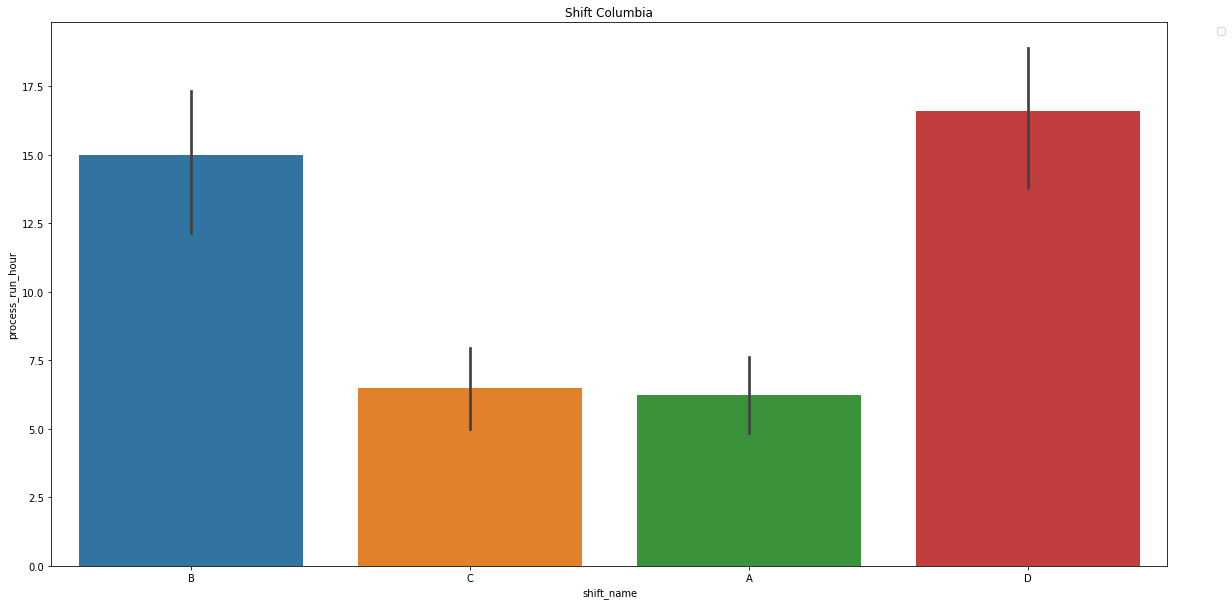

In [18]:
plt.figure(figsize=(20,10))
sns.barplot(x    = "shift_name",
            y    = "process_run_hour",
            data = shift_df_test
           )
plt.title("Shift Columbia")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

No handles with labels found to put in legend.


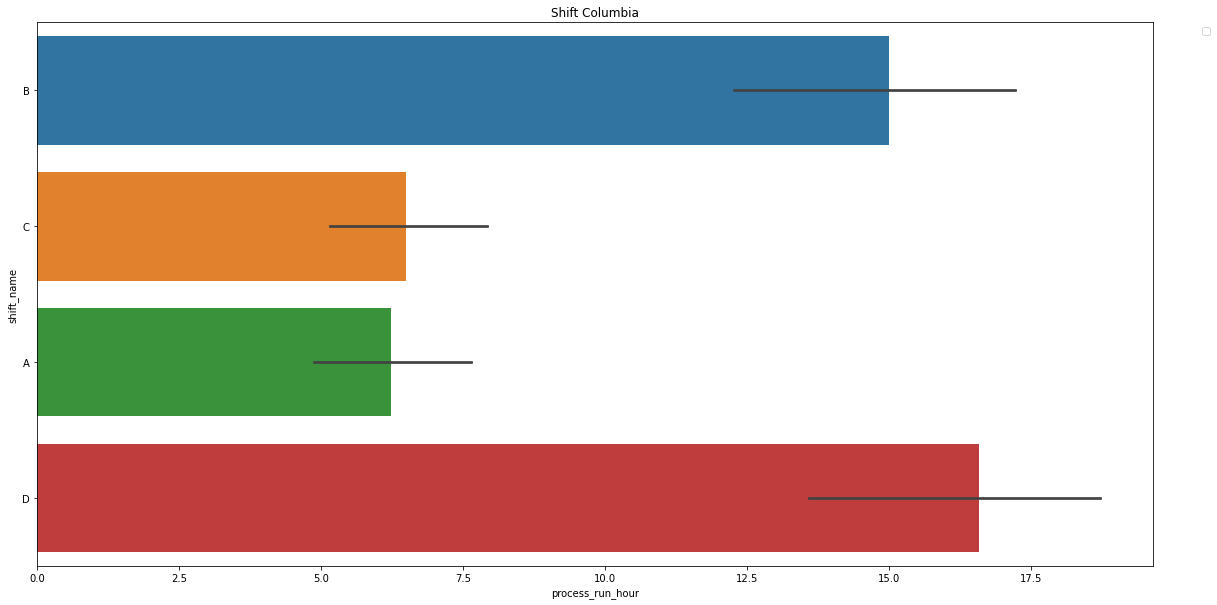

In [19]:
plt.figure(figsize=(20,10))
sns.barplot(x    = "process_run_hour",
            y    = "shift_name",
            data = shift_df_test
           )
plt.title("Shift Columbia")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

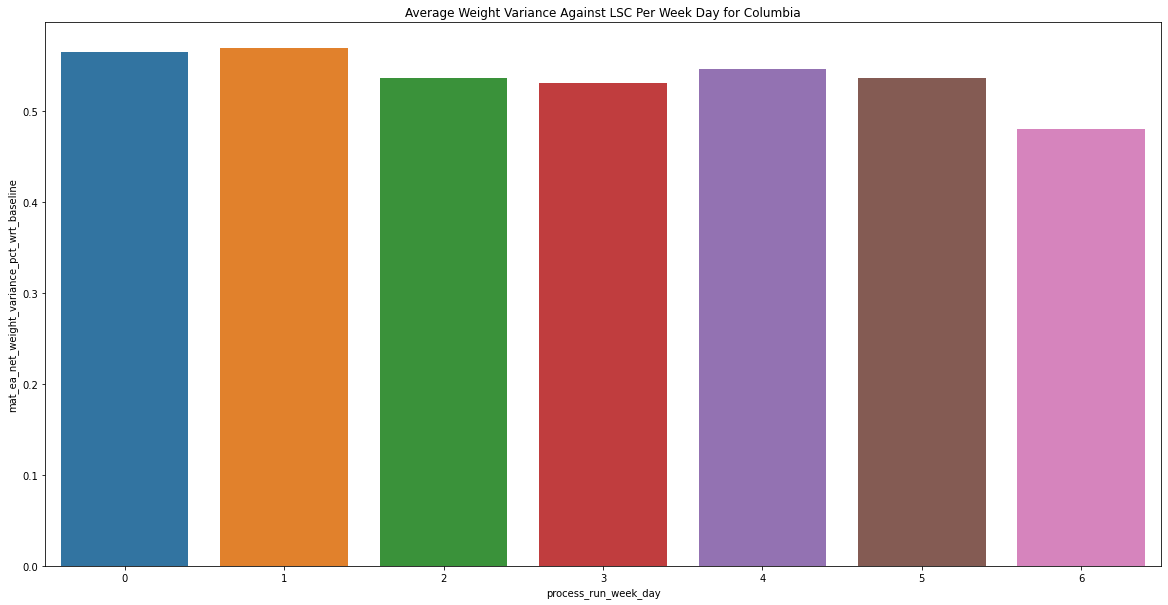

In [20]:
# Finding plant-day wise performance using average of mat_ea_net_weight_variance_pct_wrt_baseline
df_plant_day_avg_filling_variance = df.groupby(['plant_id', 'process_run_week_day']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : 'mean'}).reset_index()
df_plant_day_avg_filling_variance.sort_values(by=['mat_ea_net_weight_variance_pct_wrt_baseline'], ascending = [False], inplace = True)
# Plotting the day wise performance for plant Columbia
plt.figure(figsize=(20,10))
sns.barplot(x    = "process_run_week_day",
            y    = "mat_ea_net_weight_variance_pct_wrt_baseline",
            data = df_plant_day_avg_filling_variance
           )
plt.title("Average Weight Variance Against LSC Per Week Day for Columbia")
plt.show()

In [21]:
df_plant_day_avg_filling_variance_agg = df_plant_day_avg_filling_variance.groupby(['plant_id', 'process_run_week_day']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]}).reset_index()
df_plant_day_avg_filling_variance_agg.columns = ['plant_id', 'process_run_week_day', 'mat_ea_net_weight_variance_pct_wrt_baseline_min_val', 'mat_ea_net_weight_variance_pct_wrt_baseline_max_val', 'mat_ea_net_weight_variance_pct_wrt_baseline_avg_val', 'mat_ea_net_weight_variance_pct_wrt_baseline_median_val']
df_plant_day_avg_filling_variance_agg.sort_values(by=['mat_ea_net_weight_variance_pct_wrt_baseline_max_val', 'mat_ea_net_weight_variance_pct_wrt_baseline_avg_val'], ascending=[False, False])

,plant_id,process_run_week_day,mat_ea_net_weight_variance_pct_wrt_baseline_min_val,mat_ea_net_weight_variance_pct_wrt_baseline_max_val,mat_ea_net_weight_variance_pct_wrt_baseline_avg_val,mat_ea_net_weight_variance_pct_wrt_baseline_median_val
1,8330,1,0.569242,0.569242,0.569242,0.569242
0,8330,0,0.564958,0.564958,0.564958,0.564958
4,8330,4,0.546146,0.546146,0.546146,0.546146
2,8330,2,0.536698,0.536698,0.536698,0.536698
5,8330,5,0.535967,0.535967,0.535967,0.535967
3,8330,3,0.530860,0.530860,0.530860,0.530860
6,8330,6,0.480159,0.480159,0.480159,0.480159


We see in terms of average over weight comparison, for Columbia, Sunday and Friday are worse than other days.

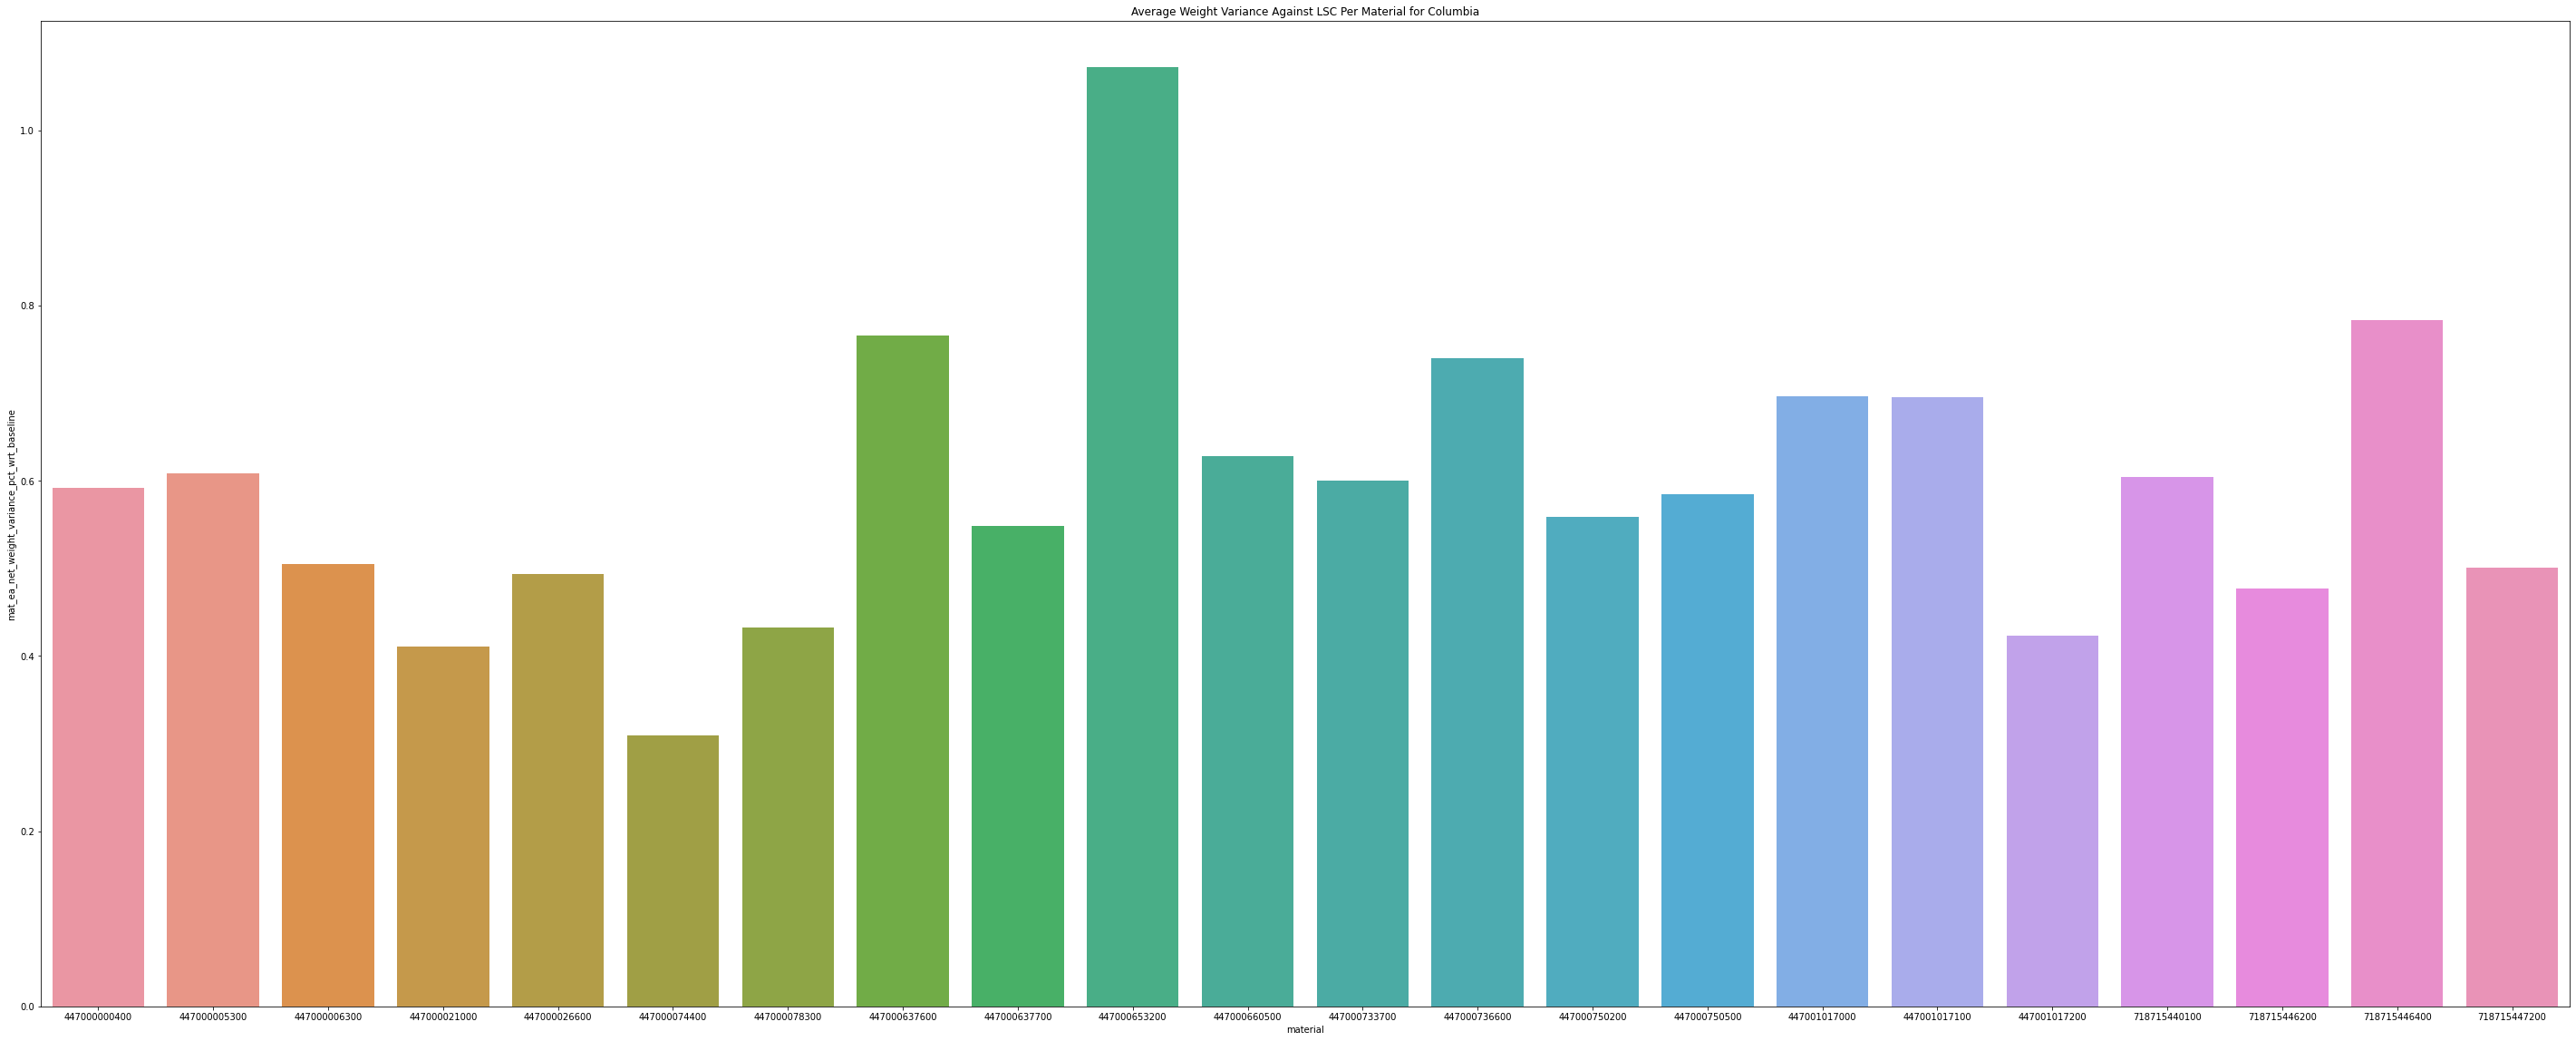

In [22]:
# Finding plant-material wise performance using average of mat_ea_net_weight_variance_pct_wrt_baseline
df_plant_day_avg_filling_variance = df.groupby(['plant_id', 'material']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : 'mean'}).reset_index().sort_values(by=['mat_ea_net_weight_variance_pct_wrt_baseline'], ascending=[False])
# Plotting the day wise performance for plant Columbia
plt.figure(figsize=(50,20))
sns.barplot(x    = "material",
            y    = "mat_ea_net_weight_variance_pct_wrt_baseline",
            data = df_plant_day_avg_filling_variance)
plt.title("Average Weight Variance Against LSC Per Material for Columbia")
plt.show()

In [23]:
df_plant_day_avg_filling_variance

,plant_id,material,mat_ea_net_weight_variance_pct_wrt_baseline
9,8330,447000653200,1.071642
20,8330,718715446400,0.782974
7,8330,447000637600,0.765777
12,8330,447000736600,0.739426
15,8330,447001017000,0.696532
16,8330,447001017100,0.695746
10,8330,447000660500,0.628458
1,8330,447000005300,0.608176
18,8330,718715440100,0.604249
11,8330,447000733700,0.599796


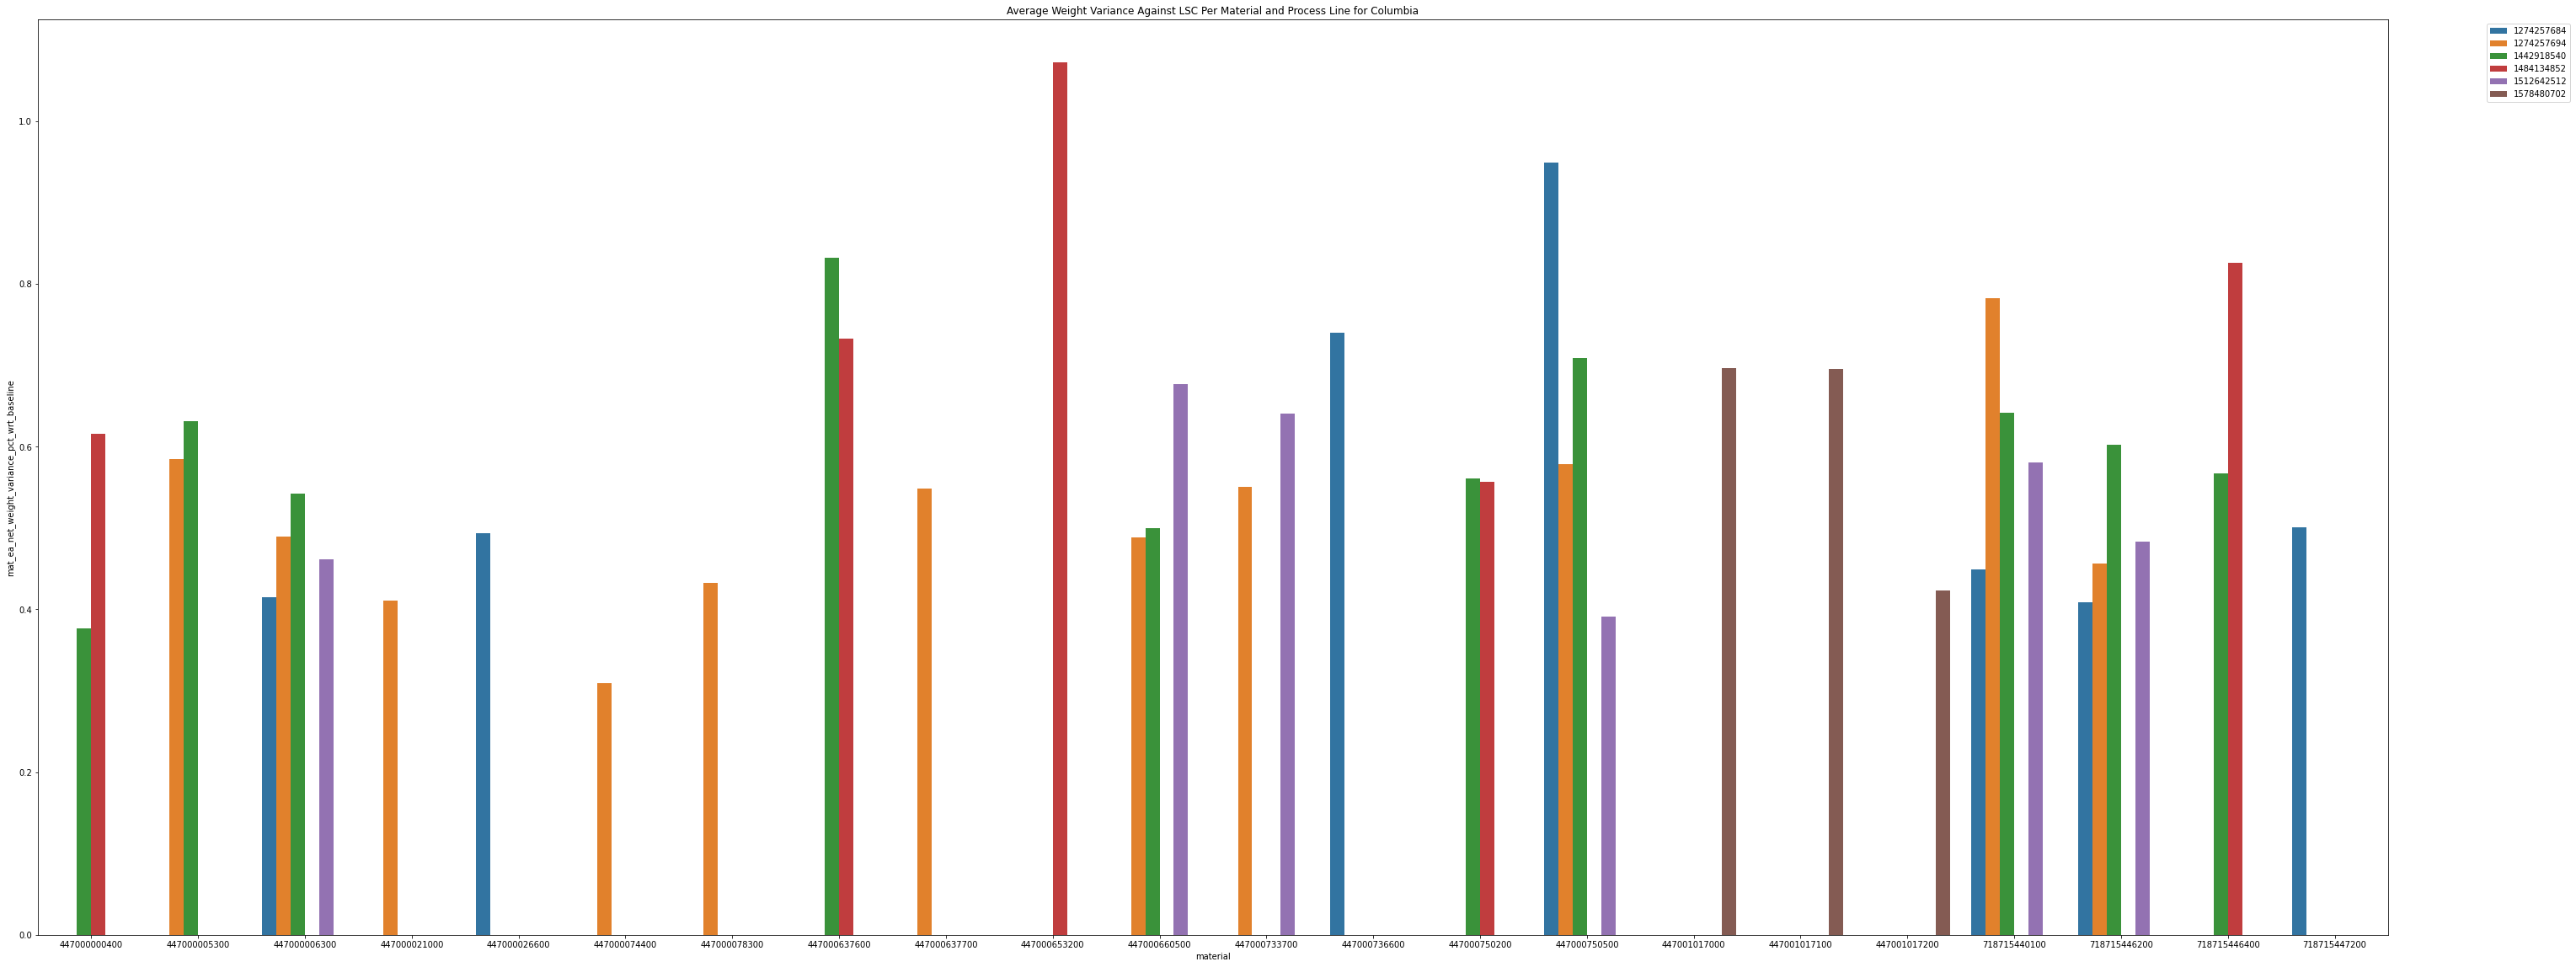

In [24]:
# Finding plant-material wise performance using average of mat_ea_net_weight_variance_pct_wrt_baseline
df_plant_day_avg_filling_variance = df.groupby(['plant_id', 'material', 'process_id']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : 'mean'}).reset_index()
# Plotting the day wise performance for plant Columbia
plt.figure(figsize=(50,20))
sns.barplot(x    = "material",
            y    = "mat_ea_net_weight_variance_pct_wrt_baseline",
            hue  = 'process_id',
            data = df_plant_day_avg_filling_variance)
plt.title("Average Weight Variance Against LSC Per Material and Process Line for Columbia")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

We see a material can be produced by multiple lines and their overfill performace varry.

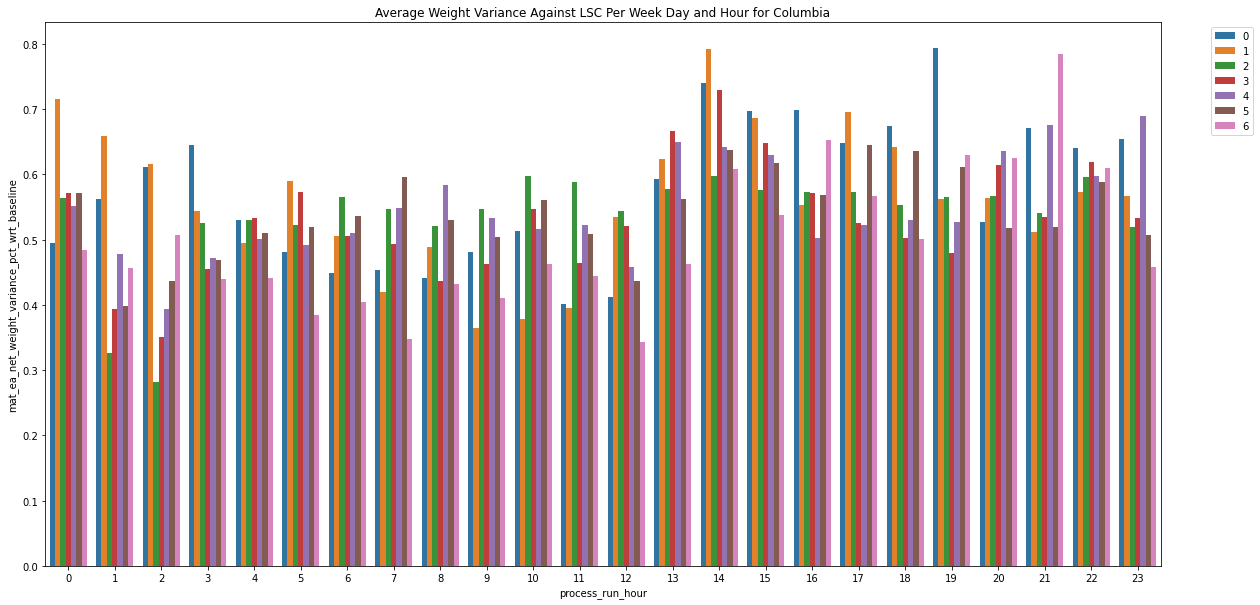

In [25]:
# Finding plant-day wise performance using average of mat_ea_net_weight_variance_pct_wrt_baseline
df_plant_day_hour_avg_filling_variance = df.groupby(['plant_id', 'process_run_week_day', 'process_run_hour']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : 'mean'}).reset_index()
# Plotting the day wise performance for plant Columbia
plt.figure(figsize=(20,10))
sns.barplot(x    = "process_run_hour",
            y    = "mat_ea_net_weight_variance_pct_wrt_baseline",
            hue  = 'process_run_week_day',
            data = df_plant_day_hour_avg_filling_variance)
plt.title("Average Weight Variance Against LSC Per Week Day and Hour for Columbia")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

Overfilling is worst on first couple of hours or last couple of hours on each day.

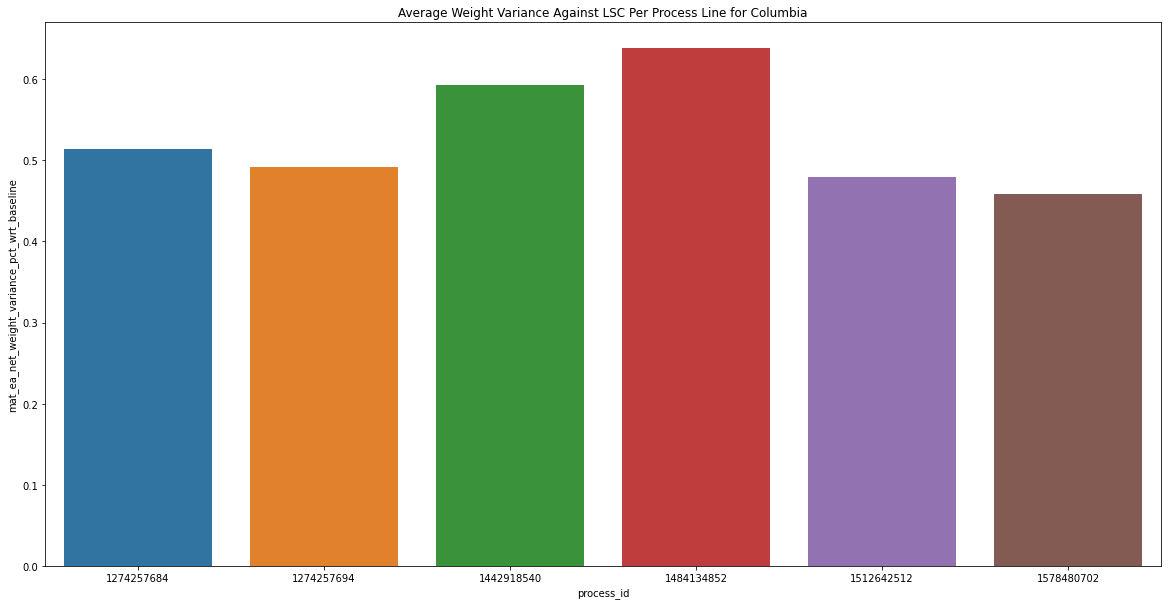

In [27]:
# Finding plant-process line wise performance using average of mat_ea_net_weight_variance_pct_wrt_baseline
df_process_line_avg_filling_variance = df.groupby(['plant_id', 'process_id']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : 'mean'}).reset_index().sort_values(by=['mat_ea_net_weight_variance_pct_wrt_baseline'], ascending = [False])
# Plotting the day wise performance for plant Columbia
plt.figure(figsize=(20,10))
sns.barplot(x    = "process_id",
            y    = "mat_ea_net_weight_variance_pct_wrt_baseline",
            data = df_process_line_avg_filling_variance)
plt.title("Average Weight Variance Against LSC Per Process Line for Columbia")
plt.show()

We see in terms of average over weight comparison, for Columbia, process line 148413852 is the worst followed by 1442918540 process line.


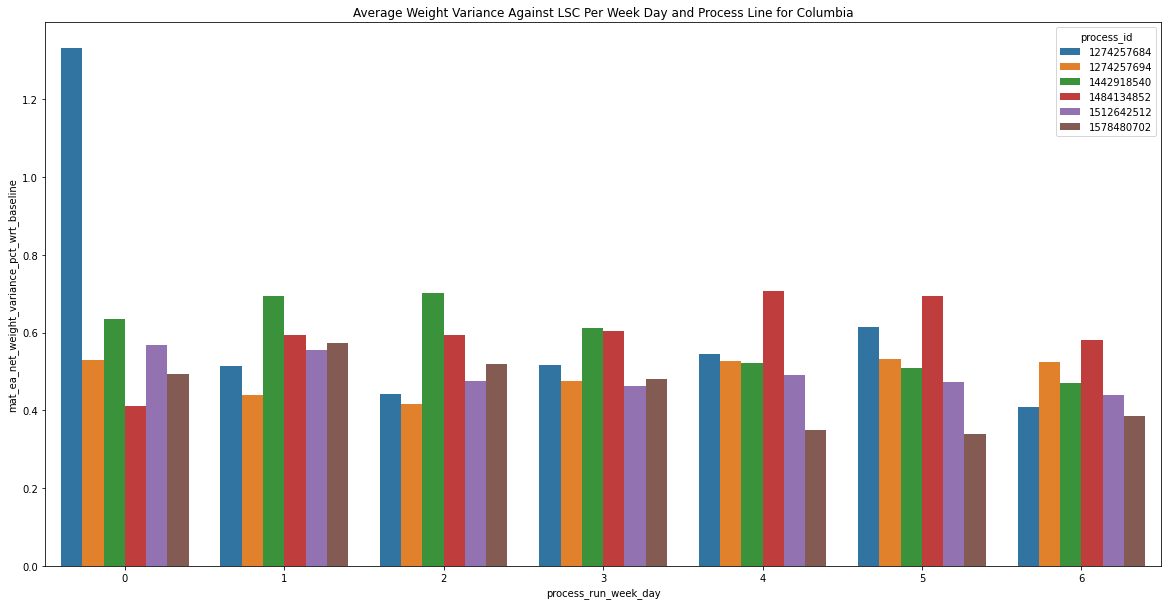

In [28]:
# Finding plant-day-process-line wise performance using average of mat_ea_net_weight_variance_pct_wrt_baseline
df_plant_line_day_avg_filling_variance = df.groupby(['plant_id', 'process_run_week_day', 'process_id']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : 'mean'}).reset_index().sort_values(by=['mat_ea_net_weight_variance_pct_wrt_baseline'], ascending = [False])
# Plotting the day wise performance for plant Columbia
plt.figure(figsize=(20,10))
sns.barplot(x    = "process_run_week_day",
            y    = "mat_ea_net_weight_variance_pct_wrt_baseline",
            hue  = "process_id",
            data = df_plant_line_day_avg_filling_variance)
plt.title("Average Weight Variance Against LSC Per Week Day and Process Line for Columbia")
plt.show()

We see in terms of average over weight comparison based on process line and day of the week, for Columbia, on Sunday process line 1274257684 performs worst, process line 148413852 is woose performing on Wednesday, Thursday, Friday and Saturday and on Monday and Tuesday, it's one of top 2 worst performing process line wrt overfill.

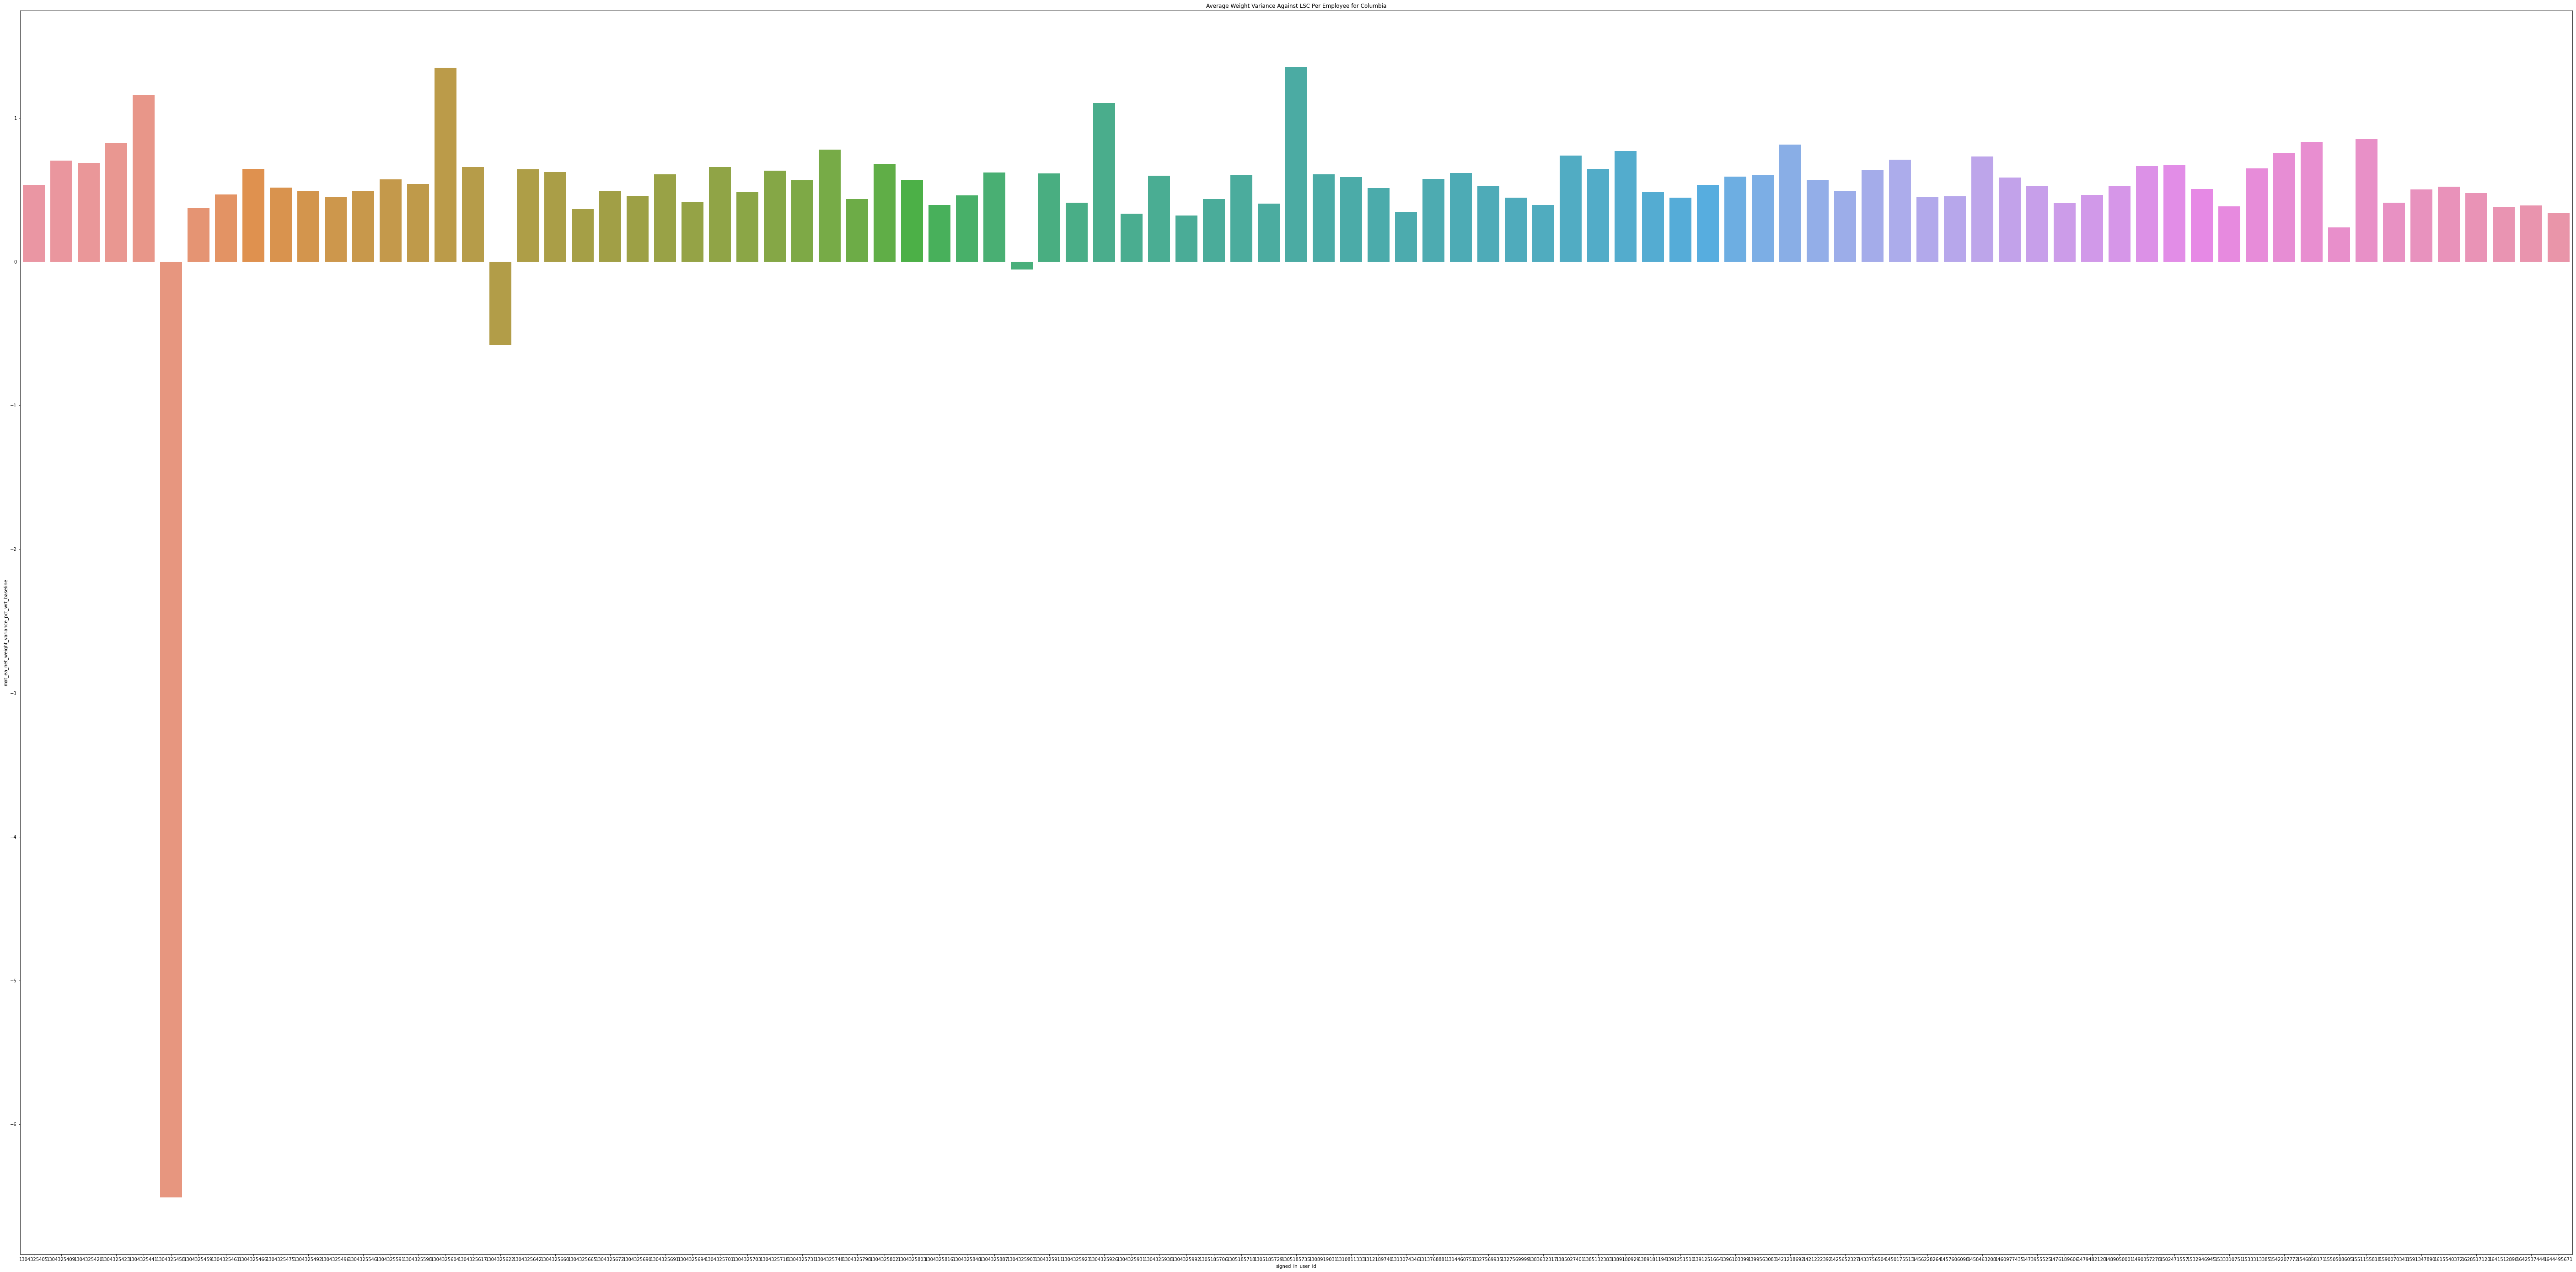

In [29]:
# Finding plant-employee wise performance using average of mat_ea_net_weight_variance_pct_wrt_baseline
df_plant_emp_avg_filling_variance = df.groupby(['plant_id', 'signed_in_user_id']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : 'mean'}).reset_index()
# Plotting the day wise performance for plant Columbia
plt.figure(figsize=(100,50))
sns.barplot(x    = "signed_in_user_id",
            y    = "mat_ea_net_weight_variance_pct_wrt_baseline",
            data = df_plant_emp_avg_filling_variance)
plt.title("Average Weight Variance Against LSC Per Employee for Columbia")
plt.show()

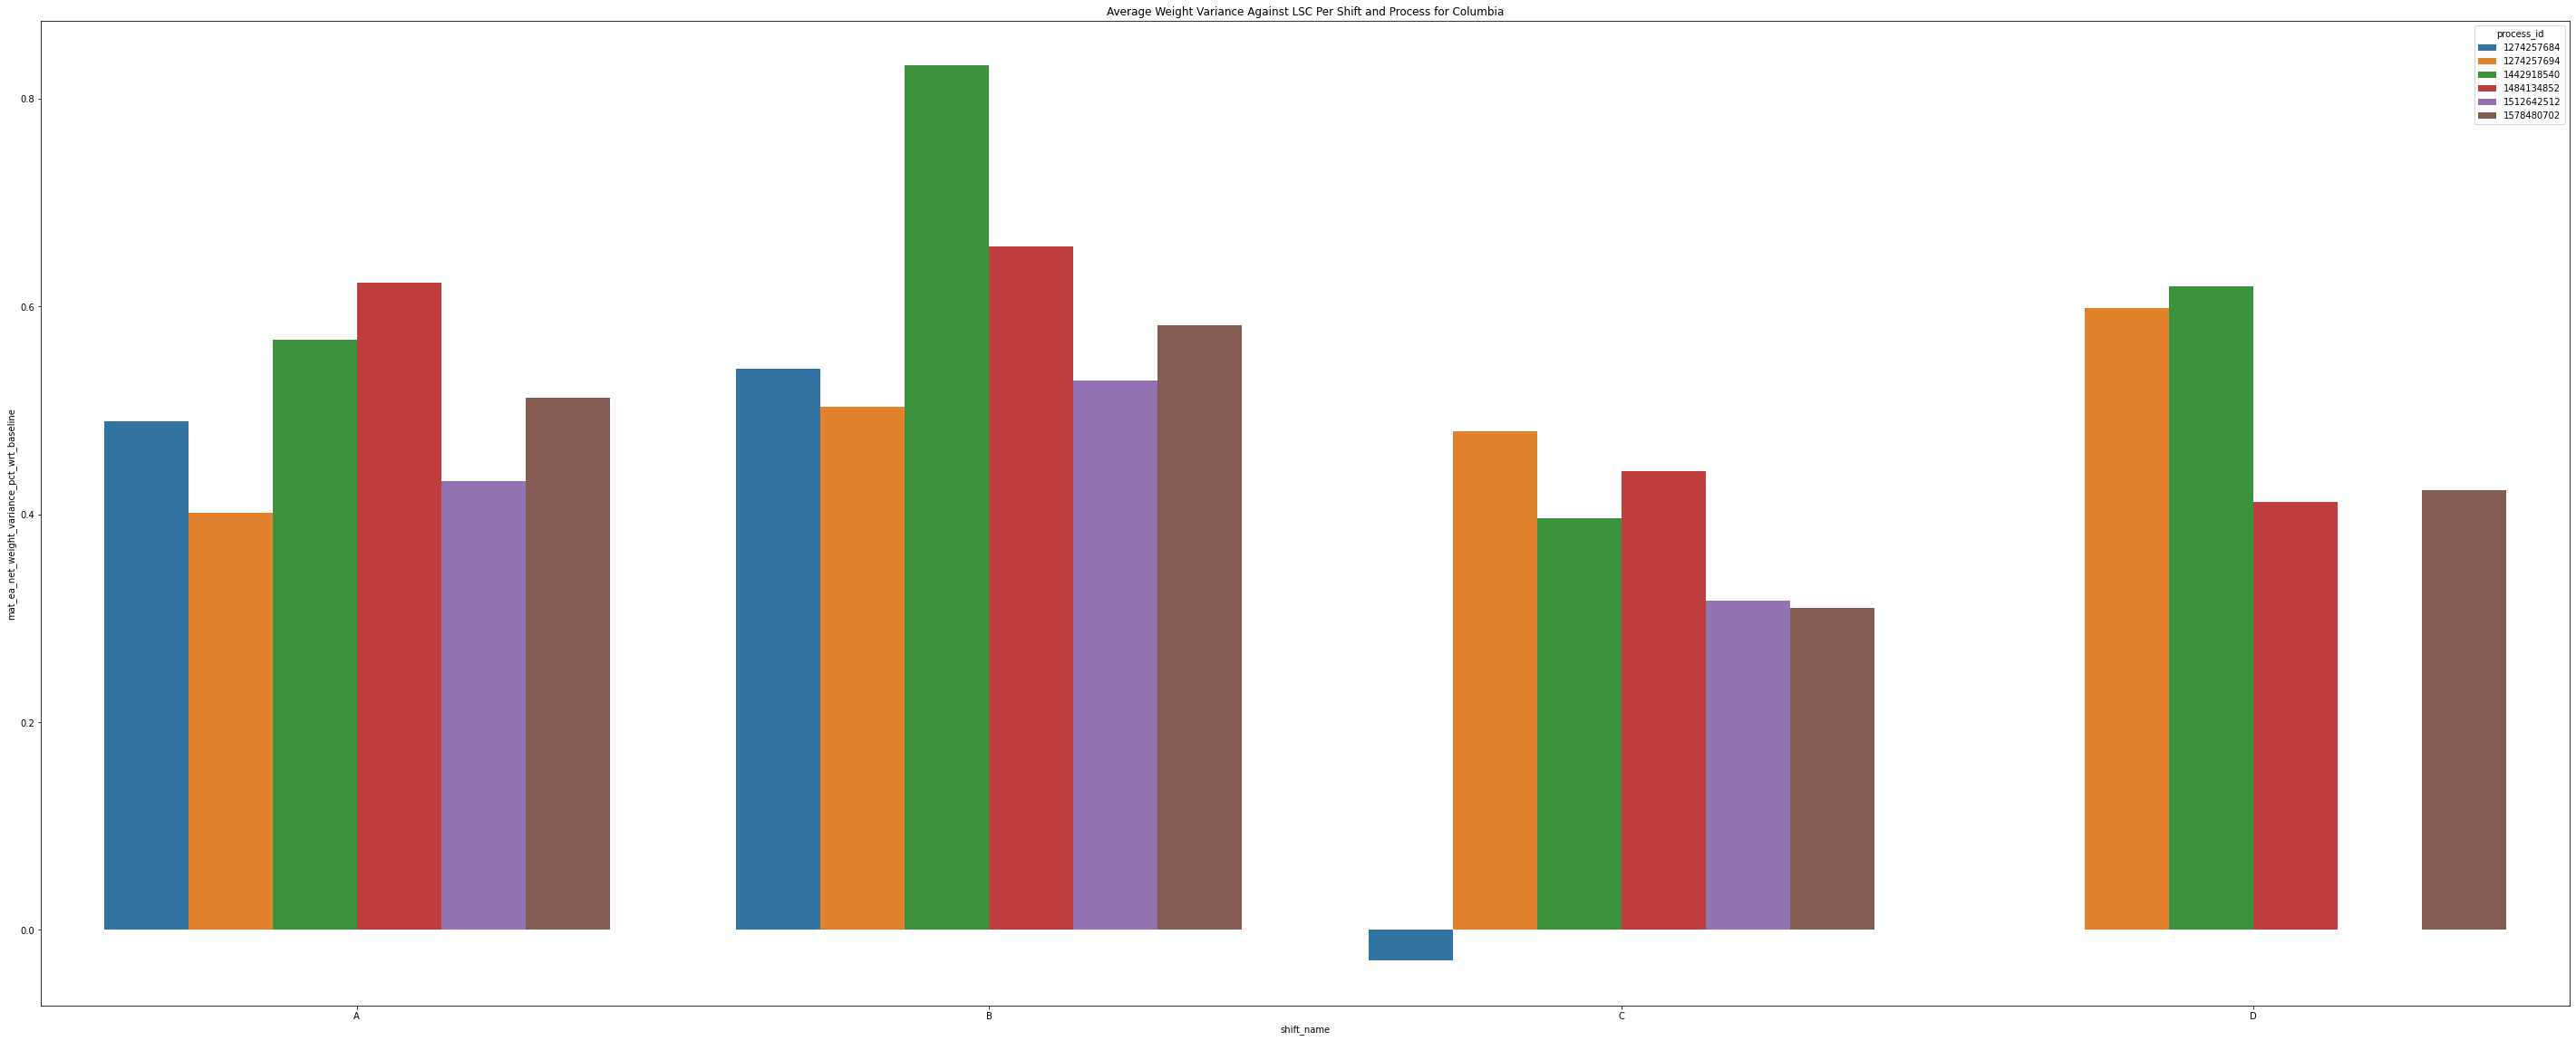

In [30]:
# Finding plant-employee wise performance using average of mat_ea_net_weight_variance_pct_wrt_baseline
df_plant_shift_process_avg_filling_variance = df.groupby(['plant_id', 'process_id', 'shift_name']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : 'mean'}).reset_index()
# Plotting the day wise performance for plant Columbia
plt.figure(figsize=(50,20))
sns.barplot(x    = "shift_name",
            y    = "mat_ea_net_weight_variance_pct_wrt_baseline",
            hue  = "process_id",
            data = df_plant_shift_process_avg_filling_variance)
plt.title("Average Weight Variance Against LSC Per Shift and Process for Columbia")
plt.show()

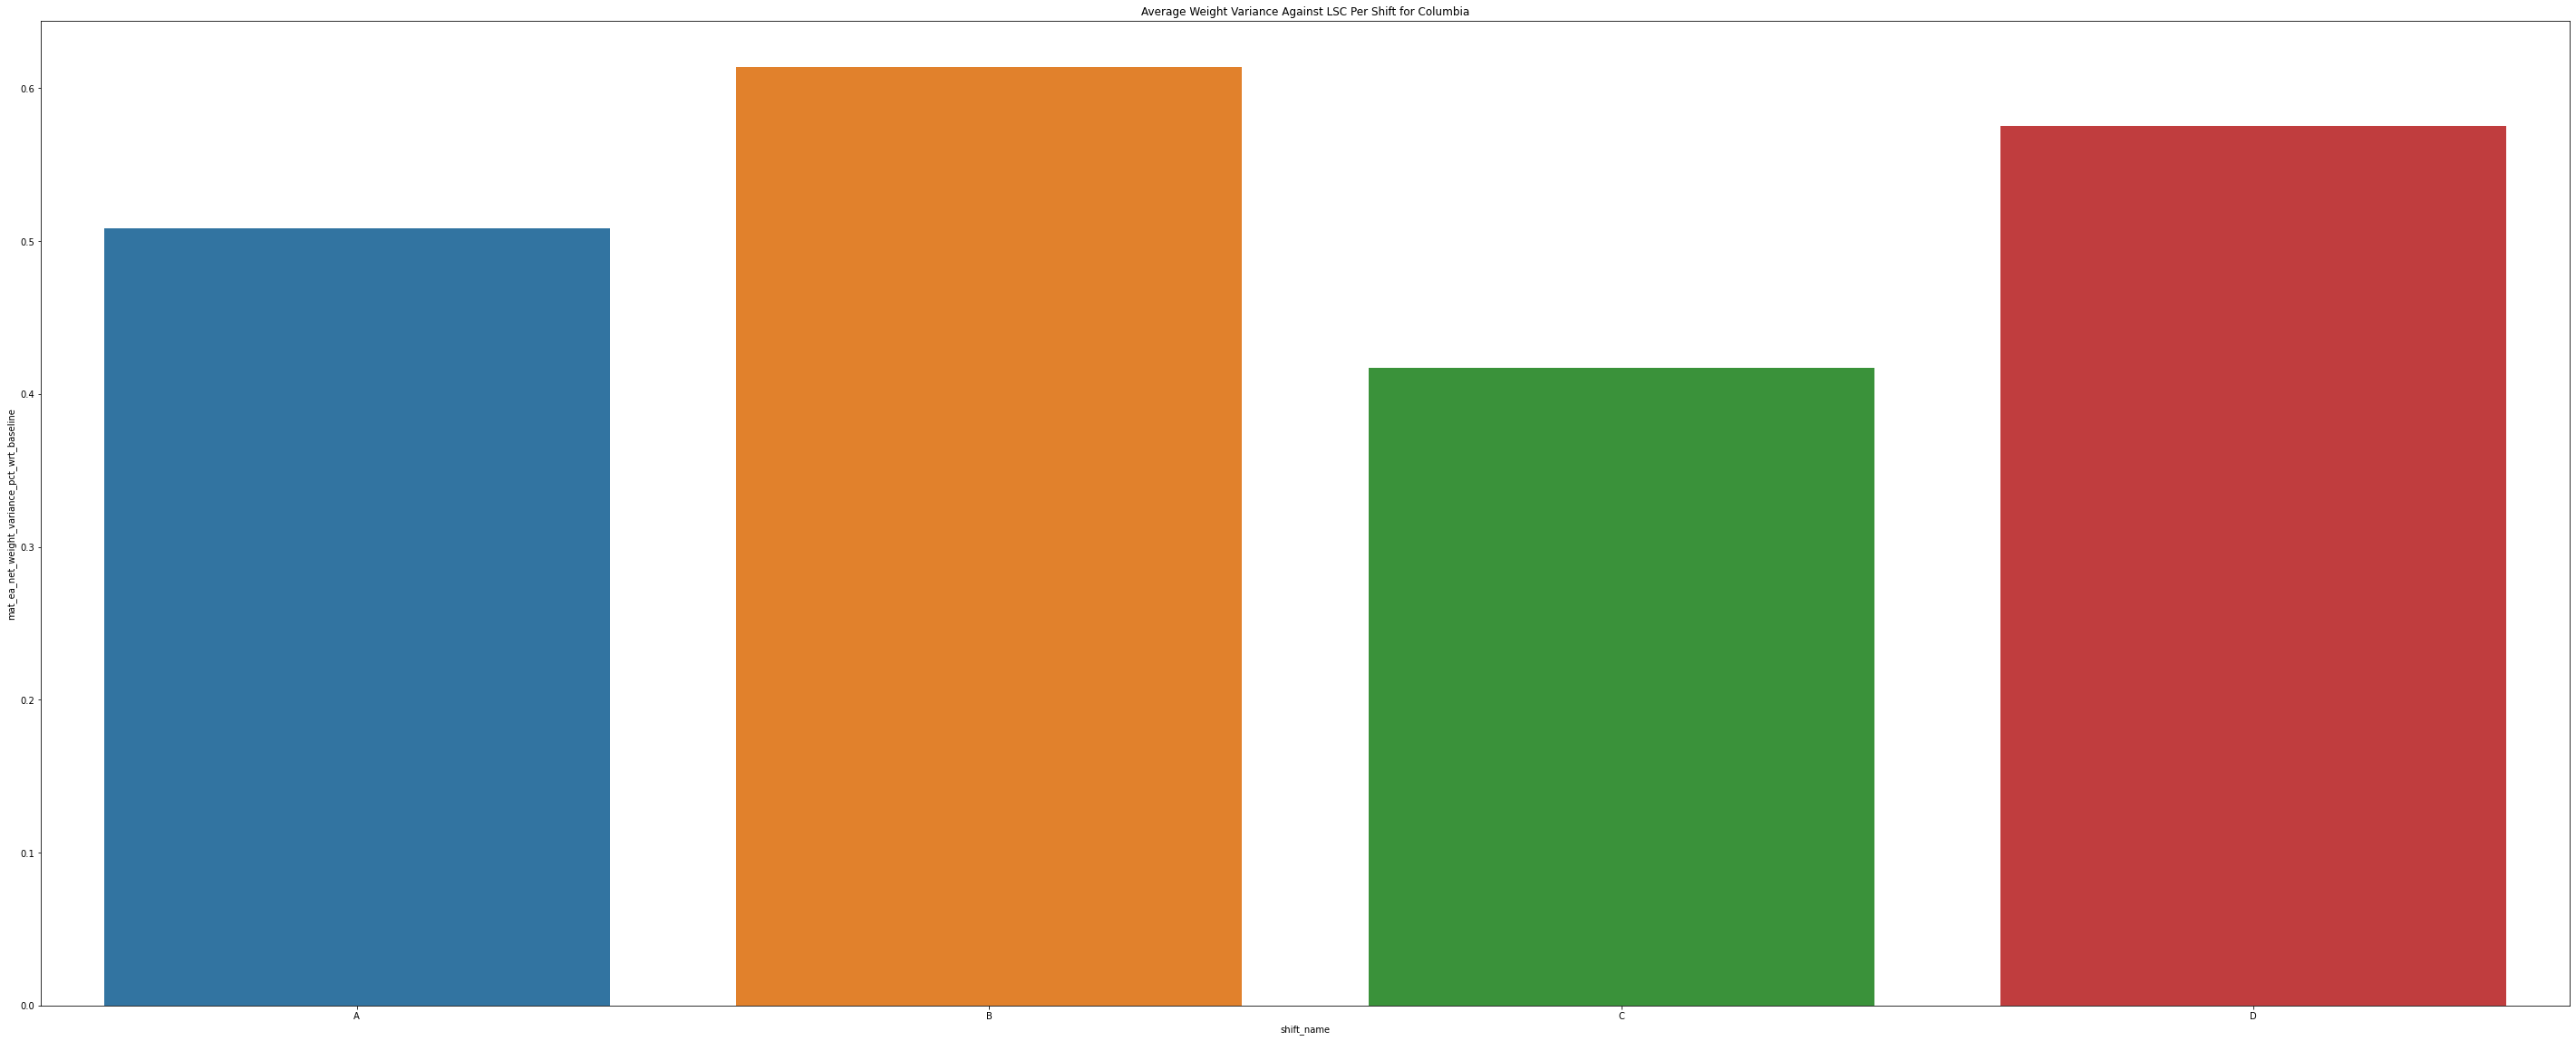

In [31]:
# Finding plant-employee wise performance using average of mat_ea_net_weight_variance_pct_wrt_baseline
df_plant_shift_avg_filling_variance = df.groupby(['plant_id', 'shift_name']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : 'mean'}).reset_index()
# Plotting the day wise performance for plant Columbia
plt.figure(figsize=(50,20))
sns.barplot(x    = "shift_name",
            y    = "mat_ea_net_weight_variance_pct_wrt_baseline",
            data = df_plant_shift_avg_filling_variance)
plt.title("Average Weight Variance Against LSC Per Shift for Columbia")
plt.show()

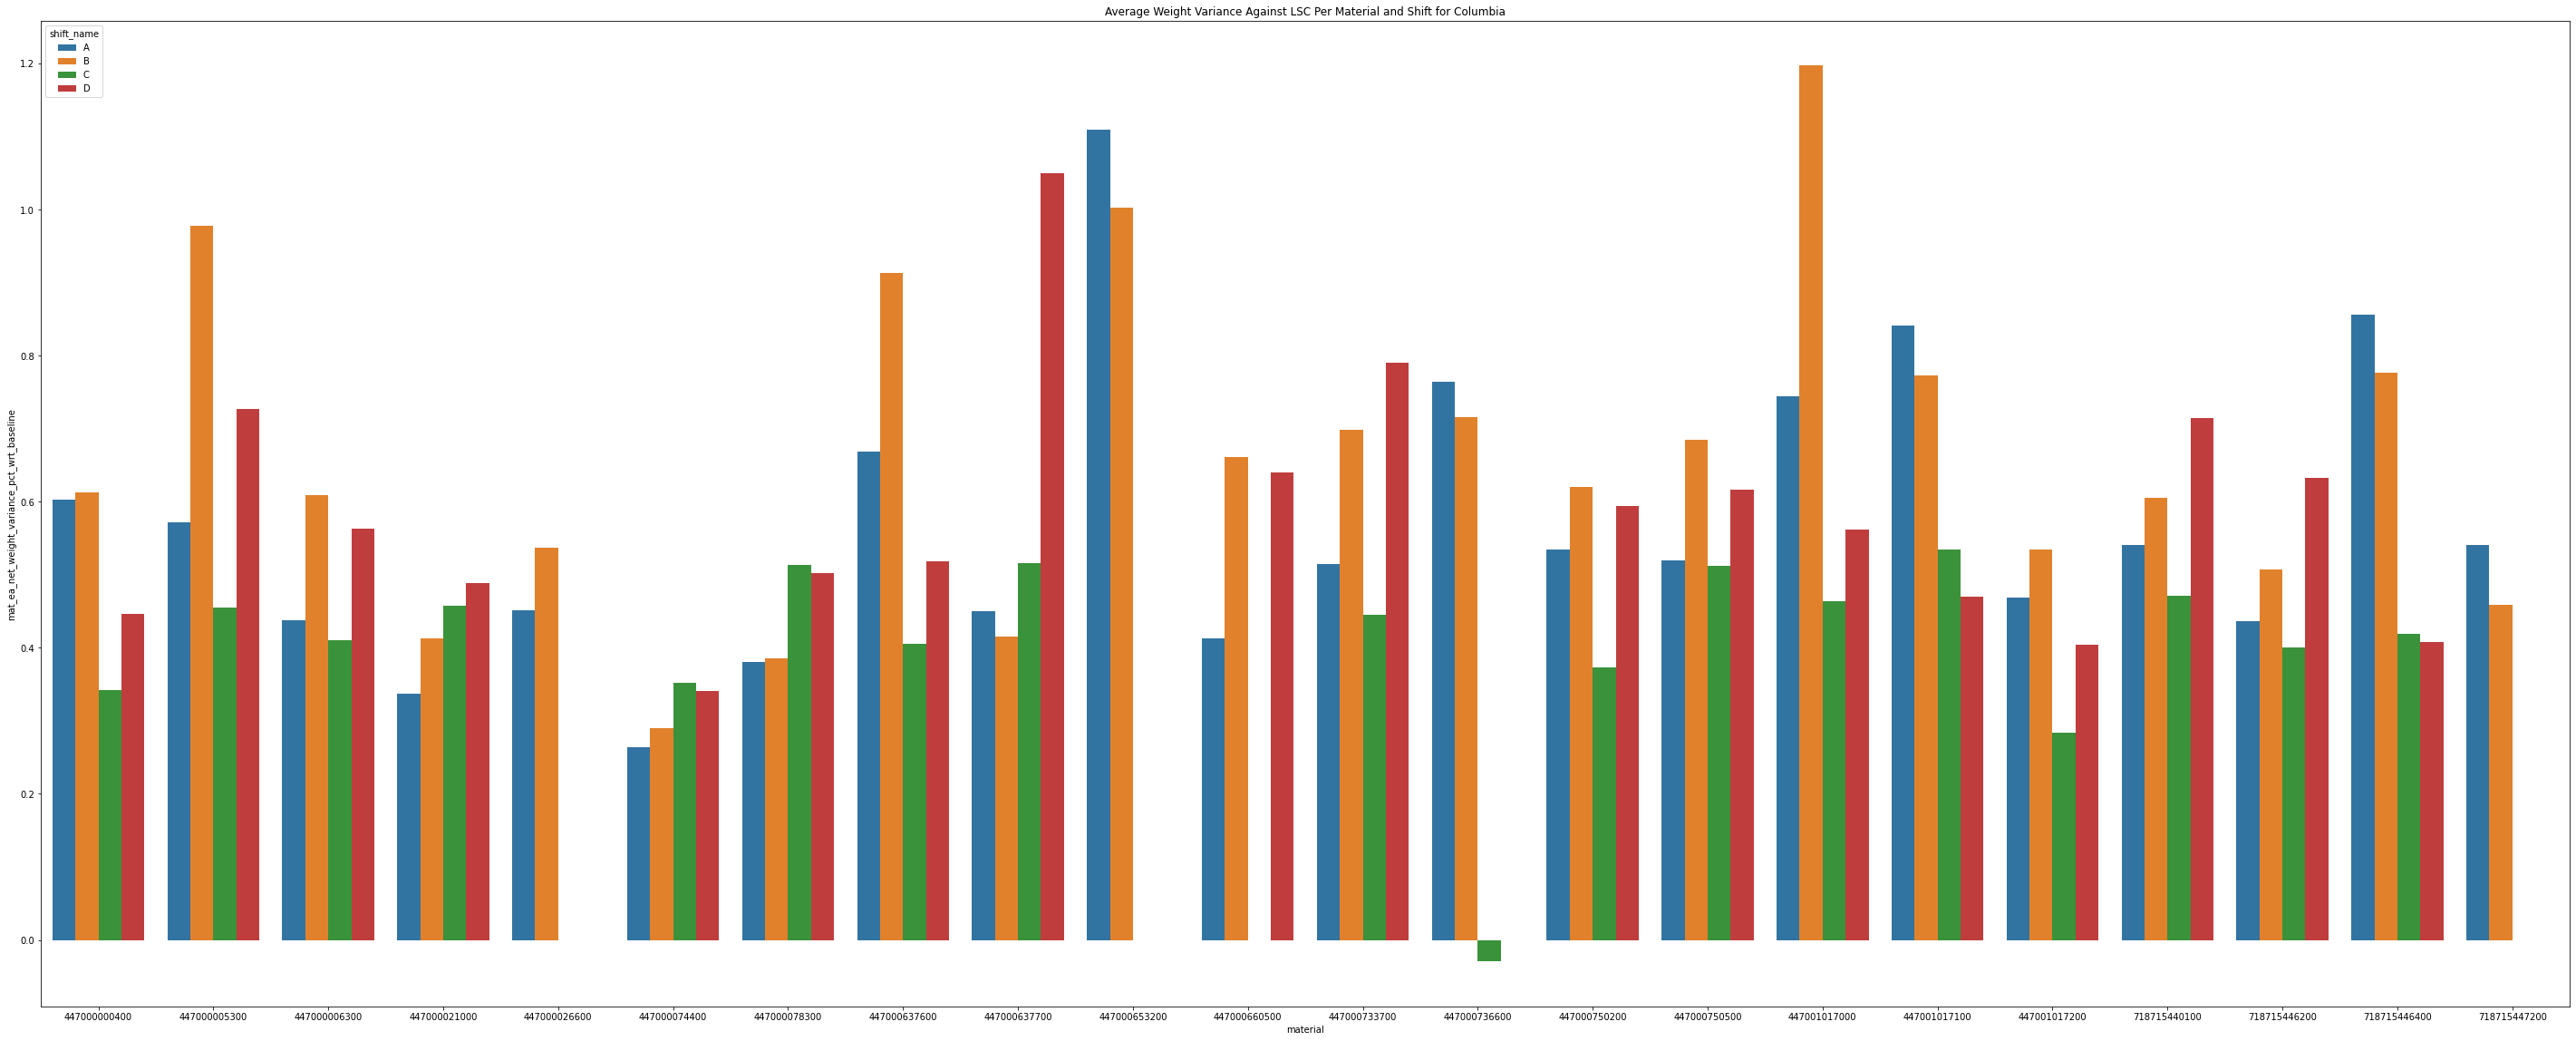

In [32]:
# Finding plant-employee wise performance using average of mat_ea_net_weight_variance_pct_wrt_baseline
df_plant_shift_material_avg_filling_variance = df.groupby(['plant_id', 'material', 'shift_name']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : 'mean'}).reset_index()
# Plotting the day wise performance for plant Columbia
plt.figure(figsize=(50,20))
sns.barplot(x    = "material",
            y    = "mat_ea_net_weight_variance_pct_wrt_baseline",
            hue  = 'shift_name',
            data = df_plant_shift_material_avg_filling_variance)
plt.title("Average Weight Variance Against LSC Per Material and Shift for Columbia")
plt.show()

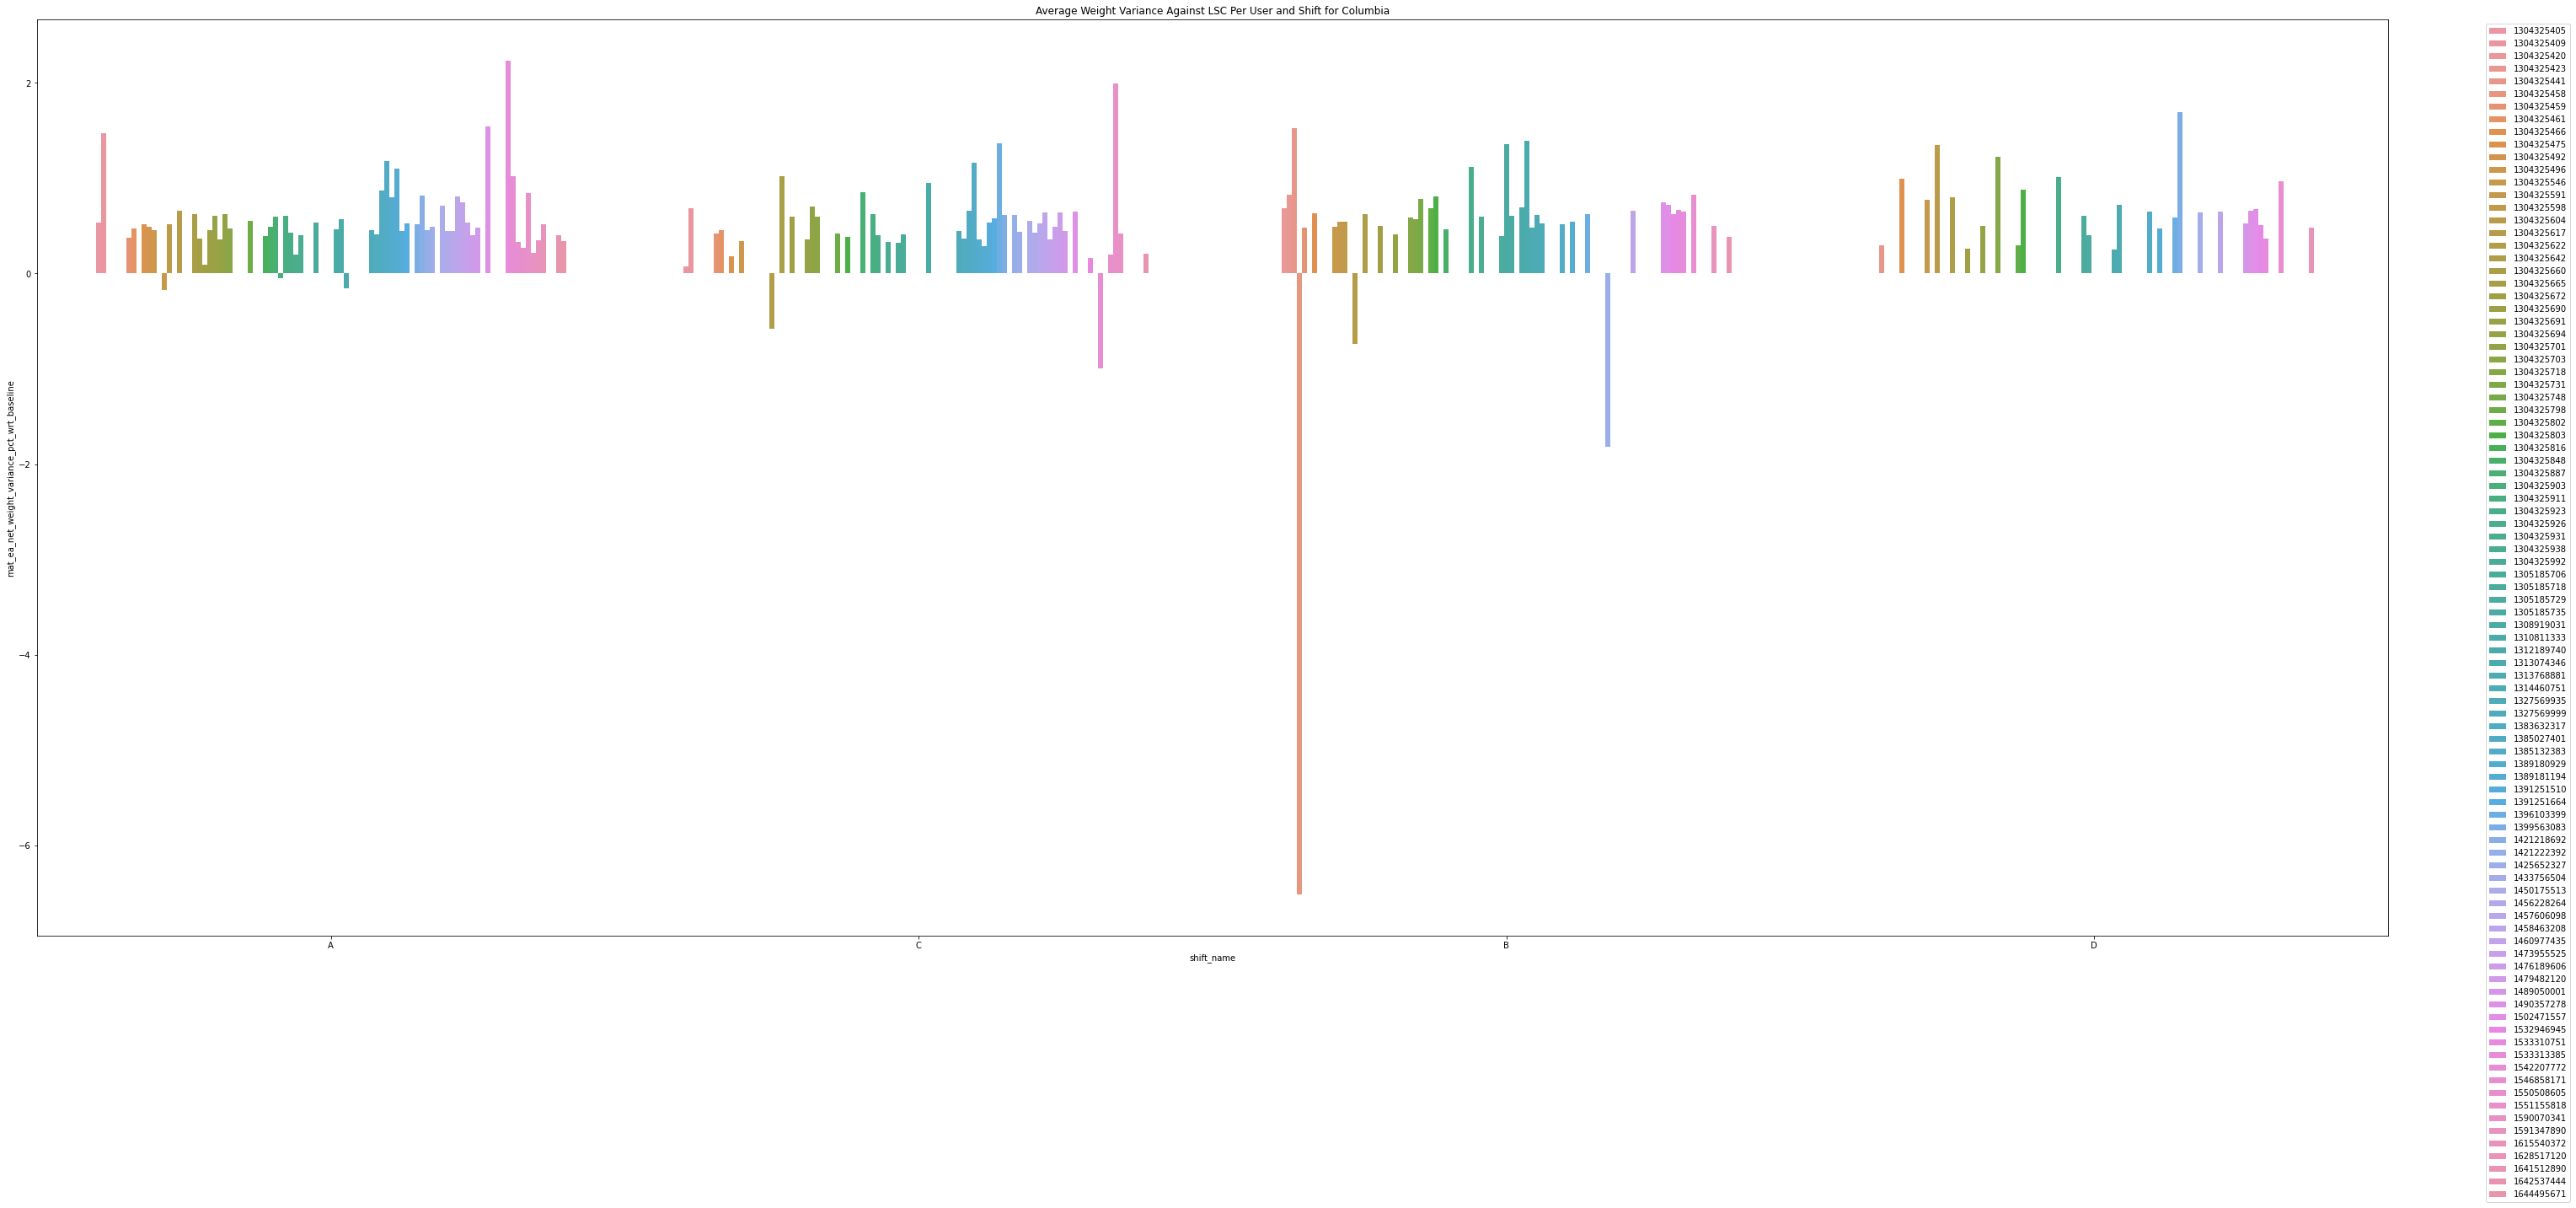

In [33]:
# Finding plant-employee wise performance using average of mat_ea_net_weight_variance_pct_wrt_baseline
df_plant_shift_emp_avg_filling_variance = df.groupby(['plant_id', 'signed_in_user_id', 'shift_name']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : 'mean'}).reset_index()
# Plotting the day wise performance for plant Columbia
plt.figure(figsize=(50,20))
sns.barplot(x    = "shift_name",
            y    = "mat_ea_net_weight_variance_pct_wrt_baseline",
            hue  = 'signed_in_user_id',
            data = df_plant_shift_emp_avg_filling_variance)
plt.title("Average Weight Variance Against LSC Per User and Shift for Columbia")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

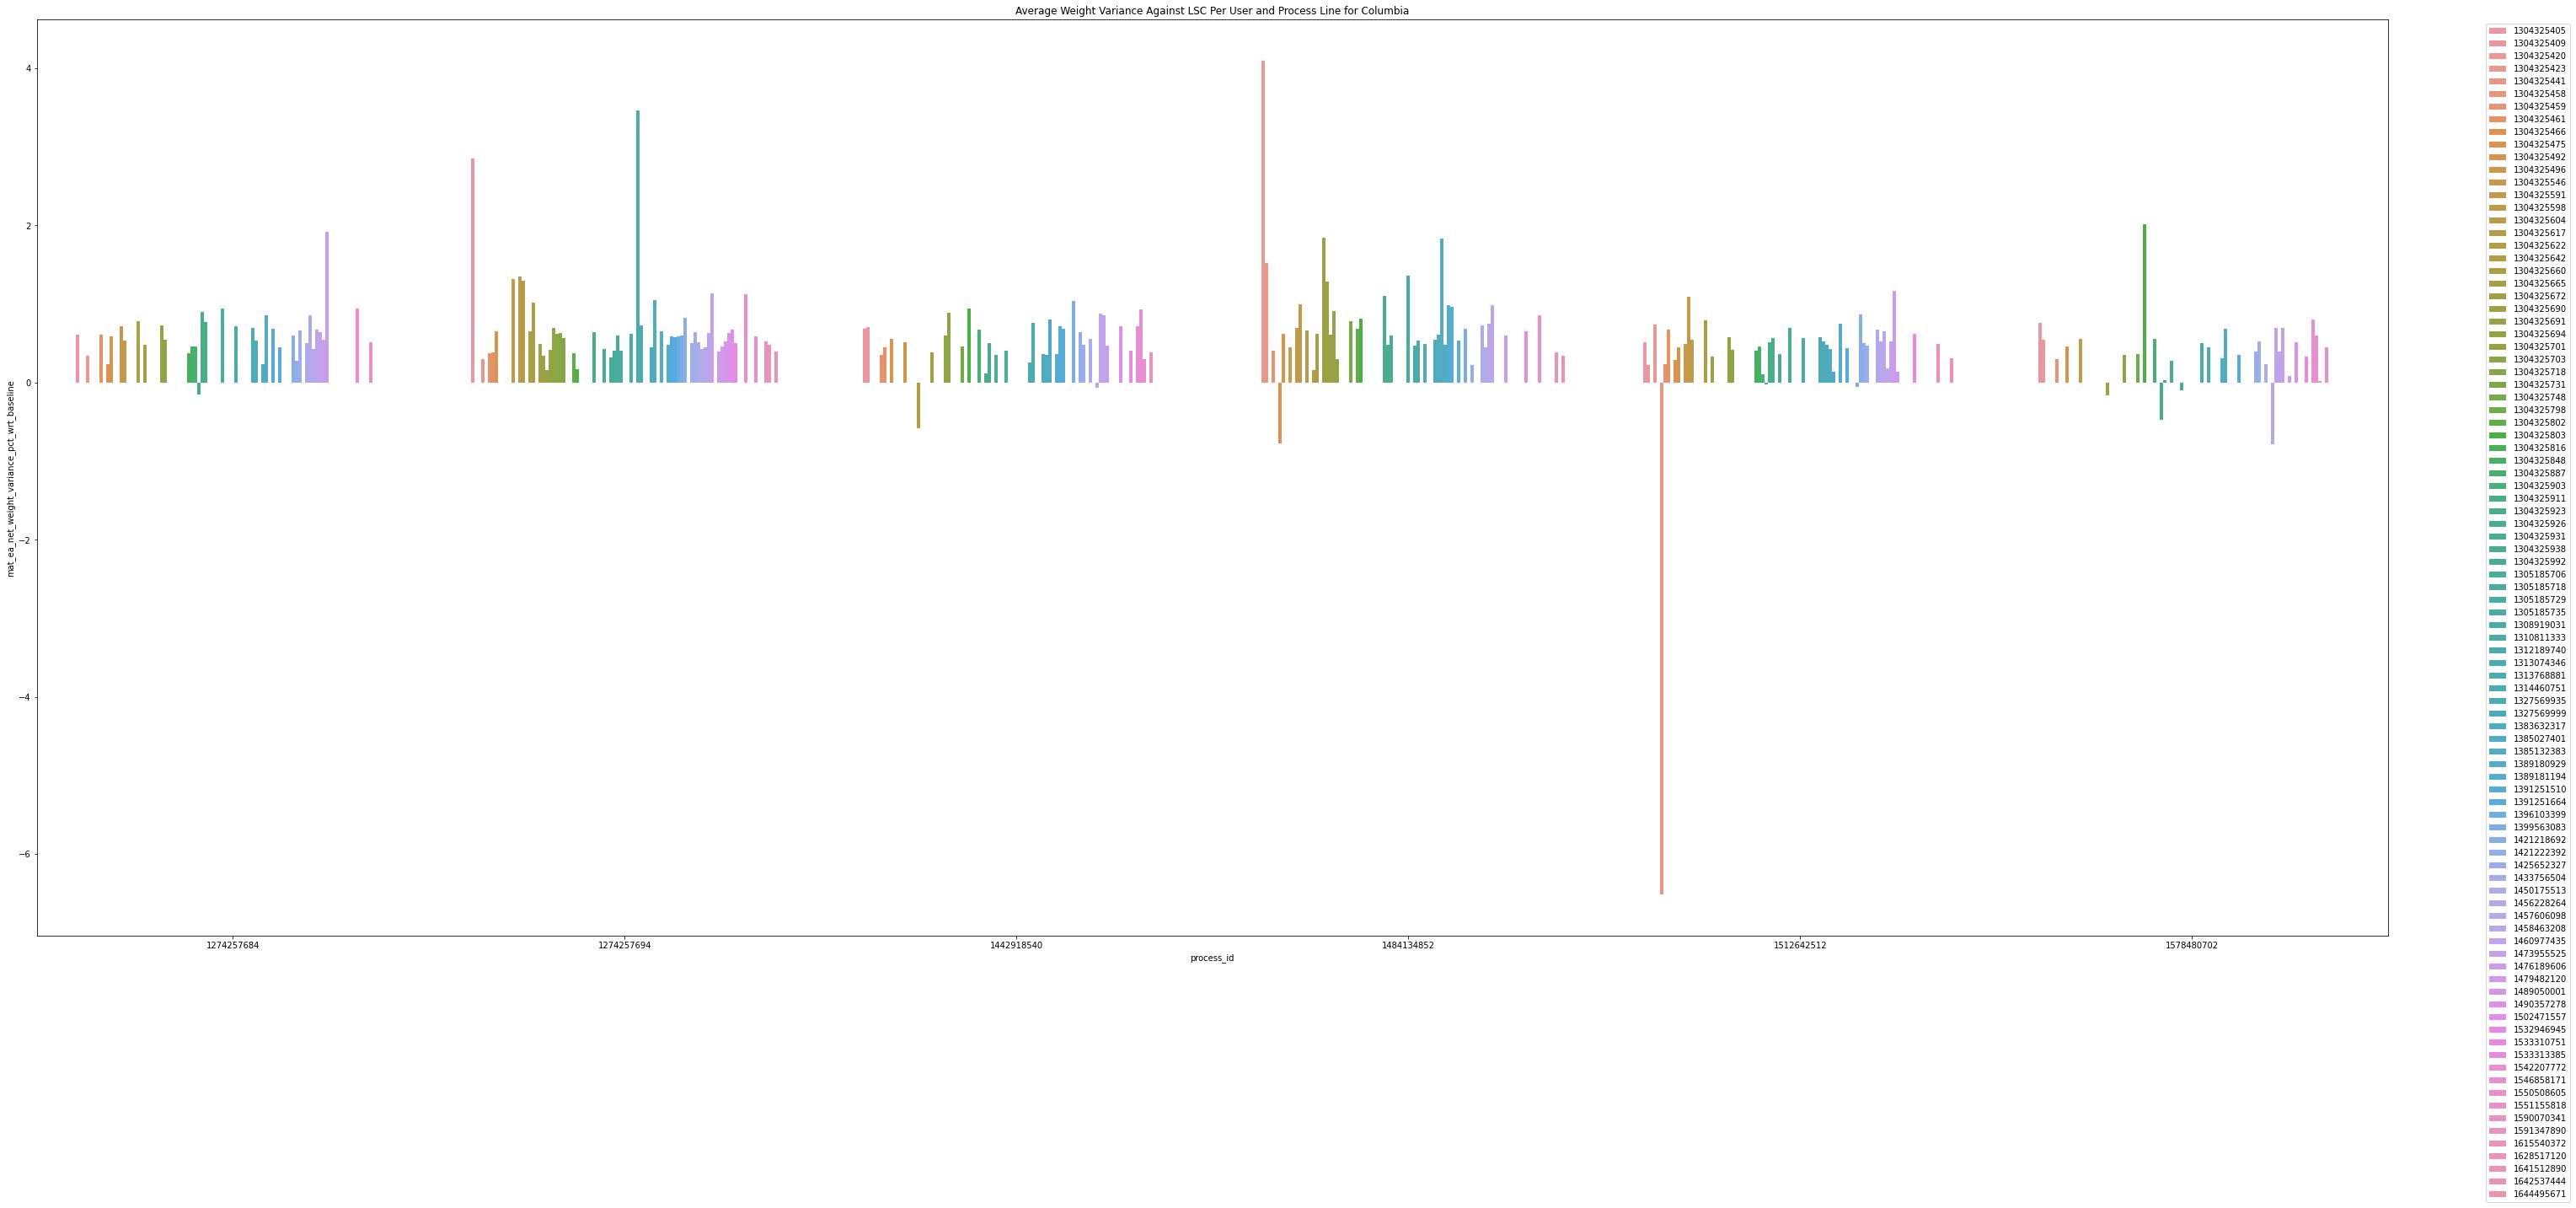

In [34]:
# Finding plant-employee wise performance using average of mat_ea_net_weight_variance_pct_wrt_baseline
df_plant_process_emp_avg_filling_variance = df.groupby(['plant_id', 'signed_in_user_id', 'process_id']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : 'mean'}).reset_index()
# Plotting the day wise performance for plant Columbia
plt.figure(figsize=(50,20))
sns.barplot(x    = "process_id",
            y    = "mat_ea_net_weight_variance_pct_wrt_baseline",
            hue  = 'signed_in_user_id',
            data = df_plant_process_emp_avg_filling_variance)
plt.title("Average Weight Variance Against LSC Per User and Process Line for Columbia")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

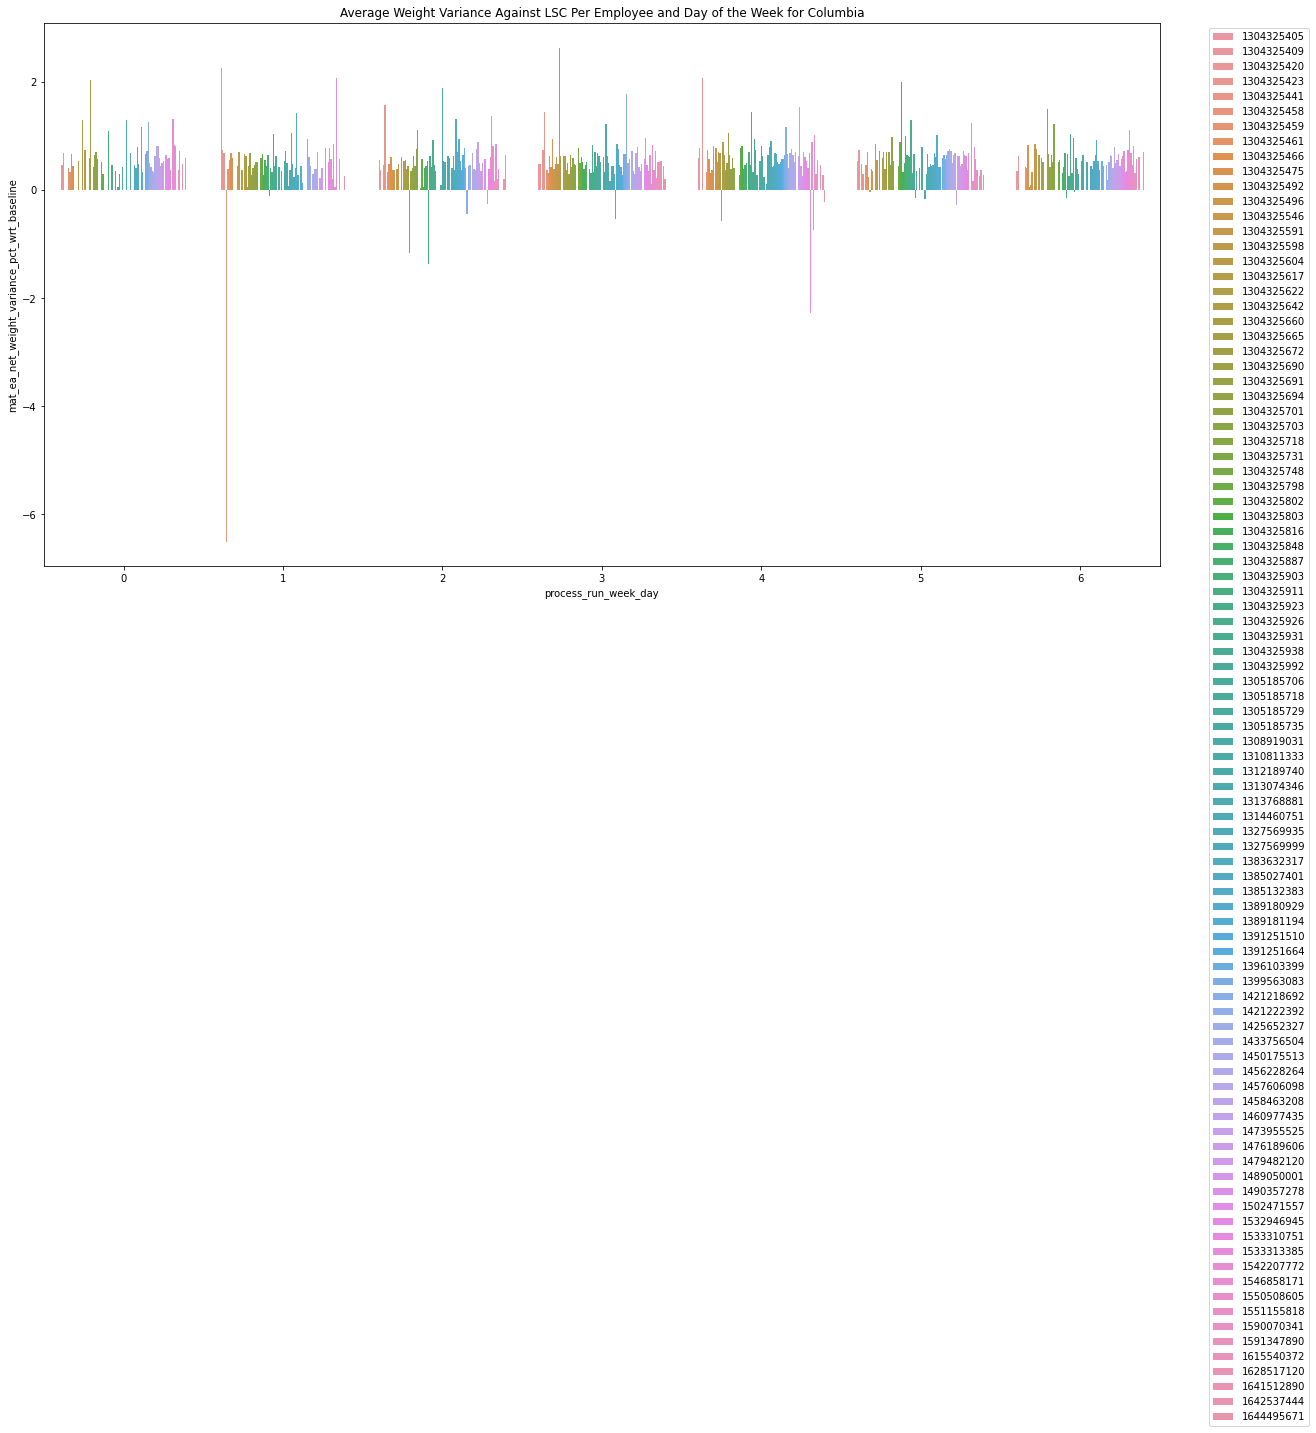

In [35]:
# Finding plant-employee-day wise performance using average of mat_ea_net_weight_variance_pct_wrt_baseline
df_plant_emp_day_avg_filling_variance = df.groupby(['plant_id', 'signed_in_user_id', 'process_run_week_day']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : 'mean'}).reset_index()
# Plotting the day wise performance for plant Columbia
plt.figure(figsize=(20,10))
sns.barplot(x    = "process_run_week_day",
            y    = "mat_ea_net_weight_variance_pct_wrt_baseline",
            hue  = "signed_in_user_id",
            data = df_plant_emp_day_avg_filling_variance)
plt.title("Average Weight Variance Against LSC Per Employee and Day of the Week for Columbia")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [36]:
# Plotting histogram for plant Columbia
'''
plt.figure(figsize=(6,2))
plt.xlim(-4,4)
sns.histplot(x    = "mat_ea_net_weight_variance_pct_wrt_baseline",
             data = df,
             hue = "process_run_week_day")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()
'''

'\nplt.figure(figsize=(6,2))\nplt.xlim(-4,4)\nsns.histplot(x    = "mat_ea_net_weight_variance_pct_wrt_baseline",\n             data = df,\n             hue = "process_run_week_day")\nplt.legend(bbox_to_anchor=(1.04,1), loc="upper left")\nplt.show()\n'

In [37]:
#Plant level stats
df.groupby(['plant_id', 'process_run_week_day']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]})

mat_ea_net_weight_variance_pct_wrt_baseline  \
                                                                     amin   
plant_id process_run_week_day                                               
8330     0                                                      -7.900000   
         1                                                      -9.110252   
         2                                                     -23.081023   
         3                                                     -17.533333   
         4                                                      -9.600000   
         5                                                     -11.353945   
         6                                                     -23.187633   

                                                               
                                     amax      mean    median  
plant_id process_run_week_day                                  
8330     0                      96.800000  0.564958  0.479744  
         1                     109.968017  0.569242  0.479744  
         2                      97.100000  0.536698  0.457143  
         3                     110.181237  0.530860  0.450000  
         4                     107.835821  0.546146  0.450000  
         5                      13.600000  0.535967  0.457143  
         6                     109.754797  0.480159  0.400000

In [38]:
#Plant, Process Line level stats
df.groupby(['plant_id', 'process_id']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]})

mat_ea_net_weight_variance_pct_wrt_baseline              \
                                                           amin        amax   
plant_id process_id                                                           
8330     1274257684                                  -17.533333   17.033333   
         1274257694                                  -23.187633   11.542857   
         1442918540                                  -23.081023  110.181237   
         1484134852                                  -19.243070   17.028571   
         1512642512                                   -9.110252   14.389748   
         1578480702                                   -8.000000    7.900000   

                                         
                         mean    median  
plant_id process_id                      
8330     1274257684  0.513772  0.433333  
         1274257694  0.491107  0.400000  
         1442918540  0.592938  0.479744  
         1484134852  0.638176  0.600000  
         1512642512  0.479769  0.400000  
         1578480702  0.458149  0.373333

In [39]:
#Plant, Day of the Week level stats
df.groupby(['plant_id', 'process_run_week_day']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]})

mat_ea_net_weight_variance_pct_wrt_baseline  \
                                                                     amin   
plant_id process_run_week_day                                               
8330     0                                                      -7.900000   
         1                                                      -9.110252   
         2                                                     -23.081023   
         3                                                     -17.533333   
         4                                                      -9.600000   
         5                                                     -11.353945   
         6                                                     -23.187633   

                                                               
                                     amax      mean    median  
plant_id process_run_week_day                                  
8330     0                      96.800000  0.564958  0.479744  
         1                     109.968017  0.569242  0.479744  
         2                      97.100000  0.536698  0.457143  
         3                     110.181237  0.530860  0.450000  
         4                     107.835821  0.546146  0.450000  
         5                      13.600000  0.535967  0.457143  
         6                     109.754797  0.480159  0.400000

In [40]:
#Plant Process Line , Day of the Week level stats
df.groupby(['plant_id', 'process_id', 'process_run_week_day']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]})

mat_ea_net_weight_variance_pct_wrt_baseline  \
                                                                                amin   
plant_id process_id process_run_week_day                                               
8330     1274257684 0                                                       0.600000   
                    1                                                      -2.500000   
                    2                                                      -4.200000   
                    3                                                     -17.533333   
                    4                                                      -1.700000   
                    5                                                      -2.300000   
                    6                                                      -1.033333   
         1274257694 0                                                      -5.916844   
                    1                                                      -4.744136   
                    2                                                      -4.957356   
                    3                                                      -4.500000   
                    4                                                      -9.600000   
                    5                                                     -11.353945   
                    6                                                     -23.187633   
         1442918540 0                                                      -3.600000   
                    1                                                      -4.317697   
                    2                                                     -23.081023   
                    3                                                      -4.957356   
                    4                                                      -4.957356   
                    5                                                      -4.400000   
                    6                                                      -5.000000   
         1484134852 0                                                      -3.400000   
                    1                                                      -5.500000   
                    2                                                     -19.243070   
                    3                                                      -4.914286   
                    4                                                      -6.130064   
                    5                                                      -5.142857   
                    6                                                      -6.023454   
         1512642512 0                                                      -1.400000   
                    1                                                      -9.110252   
                    2                                                      -4.600000   
                    3                                                      -3.800000   
                    4                                                      -5.400000   
                    5                                                      -4.400000   
                    6                                                      -3.464819   
         1578480702 0                                                      -7.900000   
                    1                                                      -2.400000   
                    2                                                      -2.300000   
                    3                                                      -2.453333   
                    4                                                      -2.700000   
                    5                                                      -2.600000   
                    6                                                      -8.000000   

                                                                          
     

In [41]:
df.groupby(['plant_id', 'process_id', 'process_run_hour']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]})

mat_ea_net_weight_variance_pct_wrt_baseline  \
                                                                            amin   
plant_id process_id process_run_hour                                               
8330     1274257684 0                                                  -1.800000   
                    1                                                  -2.600000   
                    2                                                  -1.400000   
                    3                                                  -3.266667   
                    4                                                  -2.000000   
...                                                                          ...   
         1578480702 19                                                 -1.100000   
                    20                                                 -1.850000   
                    21                                                 -1.700000   
                    22                                                 -1.800000   
                    23                                                 -1.500000   

                                                                    
                                          amax      mean    median  
plant_id process_id process_run_hour                                
8330     1274257684 0                 2.700000  0.439257  0.400000  
                    1                 2.400000  0.336854  0.300000  
                    2                 2.932812  0.348014  0.266667  
                    3                 2.733333  0.472393  0.400000  
                    4                 2.790615  0.458333  0.373267  
...                                        ...       ...       ...  
         1578480702 19                6.600000  0.673341  0.500000  
                    20                4.000000  0.454387  0.400000  
                    21                6.650000  0.566361  0.400000  
                    22                7.900000  0.626497  0.450000  
                    23                5.300000  0.483118  0.350000  

[144 rows x 4 columns]

In [42]:
df.groupby(['plant_id', 'process_id', 'process_run_week_day','process_run_hour']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]})

mat_ea_net_weight_variance_pct_wrt_baseline  \
                                                                                                 amin   
plant_id process_id process_run_week_day process_run_hour                                               
8330     1274257684 0                    21                                                       0.9   
                                         22                                                       0.6   
                                         23                                                       0.9   
                    1                    0                                                        0.1   
                                         1                                                        0.5   
...                                                                                               ...   
         1578480702 6                    19                                                      -0.3   
                                         20                                                      -1.6   
                                         21                                                      -0.4   
                                         22                                                      -1.5   
                                         23                                                      -1.3   

                                                                               \
                                                               amax      mean   
plant_id process_id process_run_week_day process_run_hour                       
8330     1274257684 0                    21                2.400000  1.480000   
                                         22                2.100000  1.113333   
                                         23                2.000000  1.510000   
                    1                    0                 1.800000  0.770000   
                                         1                 1.900000  1.226667   
...                                                             ...       ...   
         1578480702 6                    19                2.186667  0.702909   
                                         20                3.200000  0.305034   
                                         21                4.000000  1.013817   
                                         22                3.300000  0.603922   
                                         23                4.000000  0.505853   

                                                                     
                                                             median  
plant_id process_id process_run_week_day process_run_hour            
8330     1274257684 0                    21                1.450000  
                                         22                0.900000  
                                         23                1.550000  
                    1                    0                 0.600000  
                                         1                 1.400000  
...                                                             ...  
         1578480702 6                    19                0.746667  
                                         20                0.300000  
                                         21                0.800000  
                                         22                0.450000  
                                         23                0.300000  

[966 rows x 4 columns]

In [43]:
df.groupby(['plant_id', 'material']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]})
# Check at data level for 447000750200 and 447000006300
# anything above 20% at max

mat_ea_net_weight_variance_pct_wrt_baseline              \
                                                             amin        amax   
plant_id material                                                               
8330     447000000400                                   -5.500000   13.500000   
         447000005300                                   -4.900000   47.000000   
         447000006300                                   -9.600000   97.100000   
         447000021000                                   -2.900000    4.100000   
         447000026600                                  -17.533333   17.033333   
         447000074400                                   -5.600000    3.100000   
         447000078300                                   -4.914286   11.542857   
         447000637600                                   -5.485714   17.028571   
         447000637700                                   -2.857143    7.085714   
         447000653200                                   -5.142857   10.514286   
         447000660500                                   -1.410252   14.389748   
         447000733700                                  -11.353945    7.409382   
         447000736600                                   -2.221827    3.857092   
         447000750200                                  -23.081023  110.181237   
         447000750500                                  -23.187633  109.968017   
         447001017000                                   -1.700000    7.900000   
         447001017100                                   -2.666667    7.146667   
         447001017200                                   -8.000000    6.700000   
         718715440100                                   -9.110252    3.889748   
         718715446200                                   -4.500000    7.800000   
         718715446400                                   -3.600000    7.100000   
         718715447200                                   -1.400000    4.500000   

                                           
                           mean    median  
plant_id material                          
8330     447000000400  0.591740  0.600000  
         447000005300  0.608176  0.500000  
         447000006300  0.504886  0.400000  
         447000021000  0.410882  0.400000  
         447000026600  0.493598  0.400000  
         447000074400  0.309215  0.300000  
         447000078300  0.432293  0.457143  
         447000637600  0.765777  0.685714  
         447000637700  0.547884  0.457143  
         447000653200  1.071642  1.028571  
         447000660500  0.628458  0.489748  
         447000733700  0.599796  0.479744  
         447000736600  0.739426  0.693210  
         447000750200  0.558199  0.479744  
         447000750500  0.584120  0.479744  
         447001017000  0.696532  0.450000  
         447001017100  0.695746  0.480000  
         447001017200  0.422730  0.350000  
         718715440100  0.604249  0.589748  
         718715446200  0.476727  0.400000  
         718715446400  0.782974  0.700000  
         718715447200  0.500631  0.400000

In [44]:
df.groupby(['plant_id', 'material', 'process_id']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]})

mat_ea_net_weight_variance_pct_wrt_baseline  \
                                                                        amin   
plant_id material     process_id                                               
8330     447000000400 1442918540                                   -3.800000   
                      1484134852                                   -5.500000   
         447000005300 1274257694                                   -4.900000   
                      1442918540                                   -3.400000   
         447000006300 1274257684                                   -2.900000   
                      1274257694                                   -9.600000   
                      1442918540                                   -5.000000   
                      1512642512                                   -5.400000   
         447000021000 1274257694                                   -2.900000   
         447000026600 1274257684                                  -17.533333   
         447000074400 1274257694                                   -5.600000   
         447000078300 1274257694                                   -4.914286   
         447000637600 1442918540                                   -5.485714   
                      1484134852                                   -5.028571   
         447000637700 1274257694                                   -2.857143   
         447000653200 1484134852                                   -5.142857   
         447000660500 1274257694                                   -1.410252   
                      1442918540                                   -0.210252   
                      1512642512                                   -0.910252   
         447000733700 1274257694                                  -11.353945   
                      1512642512                                   -3.358209   
         447000736600 1274257684                                   -2.221827   
         447000750200 1442918540                                  -23.081023   
                      1484134852                                  -19.243070   
         447000750500 1274257684                                    0.159915   
                      1274257694                                  -23.187633   
                      1442918540                                   -5.383795   
                      1512642512                                   -4.211087   
         447001017000 1578480702                                   -1.700000   
         447001017100 1578480702                                   -2.666667   
         447001017200 1578480702                                   -8.000000   
         718715440100 1274257684                                   -0.510252   
                      1274257694                                   -0.910252   
                      1442918540                                   -0.910252   
                      1512642512                                   -9.110252   
         718715446200 1274257684                                   -4.200000   
                      1274257694                                   -4.500000   
                      1442918540                                   -3.600000   
                      1512642512                                   -3.800000   
         718715446400 1442918540                                   -1.800000   
                      1484134852                                   -3.600000   
         718715447200 1274257684                                   -1.400000   

                                                                  
                                        amax      mean    median  
plant_id material     process_id                                  
8330     447000000400 1442918540    3.600000  0.376145  0.400000  
                      1484134852   13.500000  0.615649  0.600000  
         447000005300 1274257694    7.600000  0.584243  0.500000  
                      14429185

In [45]:
df.groupby(['plant_id', 'material', 'process_id', 'process_run_week_day']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]})

mat_ea_net_weight_variance_pct_wrt_baseline  \
                                                                                             amin   
plant_id material     process_id process_run_week_day                                               
8330     447000000400 1442918540 1                                                      -1.600000   
                                 2                                                      -2.600000   
                                 3                                                      -2.400000   
                                 4                                                      -3.800000   
                                 5                                                      -1.800000   
...                                                                                           ...   
         718715447200 1274257684 2                                                      -1.000000   
                                 3                                                      -1.266667   
                                 4                                                      -1.400000   
                                 5                                                       0.066667   
                                 6                                                      -0.966667   

                                                                           \
                                                           amax      mean   
plant_id material     process_id process_run_week_day                       
8330     447000000400 1442918540 1                     1.600000  0.416456   
                                 2                     2.400000  0.469276   
                                 3                     2.800000  0.332774   
                                 4                     3.600000  0.376622   
                                 5                     2.000000  0.325111   
...                                                         ...       ...   
         718715447200 1274257684 2                     3.500000  0.555643   
                                 3                     4.500000  0.490246   
                                 4                     2.800000  0.504063   
                                 5                     1.466667  0.504444   
                                 6                     3.266667  0.413043   

                                                                 
                                                         median  
plant_id material     process_id process_run_week_day            
8330     447000000400 1442918540 1                     0.400000  
                                 2                     0.400000  
                                 3                     0.400000  
                                 4                     0.300000  
                                 5                     0.400000  
...                                                         ...  
         718715447200 1274257684 2                     0.366667  
                                 3                     0.400000  
                                 4                     0.433333  
                                 5                     0.416667  
                                 6                     0.333333  

[237 rows x 4 columns]

In [46]:
df.groupby(['plant_id', 'process_id', 'material', 'process_run_week_day','process_run_hour']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]})

mat_ea_net_weight_variance_pct_wrt_baseline  \
                                                                                                              amin   
plant_id process_id material     process_run_week_day process_run_hour                                               
8330     1274257684 447000006300 0                    21                                                       0.9   
                                                      22                                                       0.6   
                                                      23                                                       0.9   
                                 1                    0                                                        0.1   
                                                      1                                                        0.5   
...                                                                                                            ...   
         1578480702 447001017200 6                    19                                                      -0.3   
                                                      20                                                      -1.6   
                                                      21                                                      -0.4   
                                                      22                                                      -1.5   
                                                      23                                                      -1.3   

                                                                             \
                                                                       amax   
plant_id process_id material     process_run_week_day process_run_hour        
8330     1274257684 447000006300 0                    21                2.4   
                                                      22                2.1   
                                                      23                2.0   
                                 1                    0                 1.8   
                                                      1                 1.9   
...                                                                     ...   
         1578480702 447001017200 6                    19                1.7   
                                                      20                3.2   
                                                      21                4.0   
                                                      22                3.3   
                                                      23                4.0   

                                                                                  \
                                                                            mean   
plant_id process_id material     process_run_week_day process_run_hour             
8330     1274257684 447000006300 0                    21                1.480000   
                                                      22                1.113333   
                                                      23                1.510000   
                                 1                    0                 0.770000   
                                                      1                 1.226667   
...                                                                          ...   
         1578480702 447001017200 6                    19                0.502500   
                                                      20                0.463415   
                                                      21                1.143827   
                                                      22                0.582036   
                                                      23                0.444487   

                                                                               
                                                      

In [47]:
df.groupby(['plant_id', 'signed_in_user_id']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]})

mat_ea_net_weight_variance_pct_wrt_baseline  \
                                                                  amin   
plant_id signed_in_user_id                                               
8330     1304325405                                          -4.400000   
         1304325409                                          -3.038380   
         1304325420                                          -1.100000   
         1304325423                                          -1.400000   
         1304325441                                          -0.700000   
...                                                                ...   
         1615540372                                          -0.100000   
         1628517120                                          -1.714286   
         1641512890                                          -0.500000   
         1642537444                                          -1.400000   
         1644495671                                          -5.063966   

                                                        
                                 amax      mean median  
plant_id signed_in_user_id                              
8330     1304325405          4.957356  0.532542    0.5  
         1304325409          6.769723  0.701864    0.6  
         1304325420          3.784648  0.685828    0.7  
         1304325423         10.514286  0.827040    0.6  
         1304325441          5.400000  1.156140    0.7  
...                               ...       ...    ...  
         1615540372          1.500000  0.520000    0.4  
         1628517120          4.637527  0.477347    0.4  
         1641512890          1.000000  0.380000    0.6  
         1642537444          4.424307  0.390469    0.3  
         1644495671          4.342857  0.337015    0.3  

[93 rows x 4 columns]

In [48]:
df.groupby(['plant_id', 'signed_in_user_id', 'material']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]})

mat_ea_net_weight_variance_pct_wrt_baseline  \
                                                                               amin   
plant_id signed_in_user_id material                                                   
8330     1304325405        447000006300                                   -4.400000   
                           447000026600                                   -1.366667   
                           447000733700                                   -1.226013   
                           447000736600                                   -0.017775   
                           447000750500                                   -2.505330   
...                                                                             ...   
         1642537444        447000750500                                   -0.799574   
         1644495671        447000000400                                   -2.100000   
                           447000637600                                   -3.200000   
                           447000653200                                   -0.114286   
                           447000750200                                   -5.063966   

                                                                       
                                             amax      mean    median  
plant_id signed_in_user_id material                                    
8330     1304325405        447000006300  4.000000  0.508571  0.500000  
                           447000026600  2.100000  0.513255  0.466667  
                           447000733700  2.398721  0.675439  0.692964  
                           447000736600  2.221827  1.017893  1.048702  
                           447000750500  4.957356  0.556977  0.479744  
...                                           ...       ...       ...  
         1642537444        447000750500  1.759062  0.264155  0.159915  
         1644495671        447000000400  2.100000  0.230986  0.300000  
                           447000637600  4.342857  0.499341  0.228571  
                           447000653200  2.057143  0.902857  0.800000  
                           447000750200  2.611940  0.251866  0.373134  

[763 rows x 4 columns]

In [49]:
df.groupby(['plant_id', 'process_id', 'material']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median, np.size]})

mat_ea_net_weight_variance_pct_wrt_baseline  \
                                                                        amin   
plant_id process_id material                                                   
8330     1274257684 447000006300                                   -2.900000   
                    447000026600                                  -17.533333   
                    447000736600                                   -2.221827   
                    447000750500                                    0.159915   
                    718715440100                                   -0.510252   
                    718715446200                                   -4.200000   
                    718715447200                                   -1.400000   
         1274257694 447000005300                                   -4.900000   
                    447000006300                                   -9.600000   
                    447000021000                                   -2.900000   
                    447000074400                                   -5.600000   
                    447000078300                                   -4.914286   
                    447000637700                                   -2.857143   
                    447000660500                                   -1.410252   
                    447000733700                                  -11.353945   
                    447000750500                                  -23.187633   
                    718715440100                                   -0.910252   
                    718715446200                                   -4.500000   
         1442918540 447000000400                                   -3.800000   
                    447000005300                                   -3.400000   
                    447000006300                                   -5.000000   
                    447000637600                                   -5.485714   
                    447000660500                                   -0.210252   
                    447000750200                                  -23.081023   
                    447000750500                                   -5.383795   
                    718715440100                                   -0.910252   
                    718715446200                                   -3.600000   
                    718715446400                                   -1.800000   
         1484134852 447000000400                                   -5.500000   
                    447000637600                                   -5.028571   
                    447000653200                                   -5.142857   
                    447000750200                                  -19.243070   
                    718715446400                                   -3.600000   
         1512642512 447000006300                                   -5.400000   
                    447000660500                                   -0.910252   
                    447000733700                                   -3.358209   
                    447000750500                                   -4.211087   
                    718715440100                                   -9.110252   
                    718715446200                                   -3.800000   
         1578480702 447001017000                                   -1.700000   
                    447001017100                                   -2.666667   
                    447001017200                                   -8.000000   

                                                                         
                                        amax      mean    median   size  
plant_id process_id material                                             
8330     1274257684 447000006300    3.400000  0.415168  0.400000   2624  
                    447000026600   17.033333  0.493598  0.400000   9882  
                    447000736600    3.857092  0.739426  0.6932

In [50]:
df.groupby(['plant_id', 'signed_in_user_id', 'material', 'process_id']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]})

mat_ea_net_weight_variance_pct_wrt_baseline  \
                                                                                          amin   
plant_id signed_in_user_id material     process_id                                               
8330     1304325405        447000006300 1274257684                                   -2.900000   
                                        1512642512                                   -4.400000   
                           447000026600 1274257684                                   -1.366667   
                           447000733700 1512642512                                   -1.226013   
                           447000736600 1274257684                                   -0.017775   
...                                                                                        ...   
         1642537444        447000750500 1512642512                                   -0.799574   
         1644495671        447000000400 1484134852                                   -2.100000   
                           447000637600 1484134852                                   -3.200000   
                           447000653200 1484134852                                   -0.114286   
                           447000750200 1484134852                                   -5.063966   

                                                                        \
                                                        amax      mean   
plant_id signed_in_user_id material     process_id                       
8330     1304325405        447000006300 1274257684  1.300000  0.315000   
                                        1512642512  4.000000  0.530280   
                           447000026600 1274257684  2.100000  0.513255   
                           447000733700 1512642512  2.398721  0.675439   
                           447000736600 1274257684  2.221827  1.017893   
...                                                      ...       ...   
         1642537444        447000750500 1512642512  1.545842  0.309168   
         1644495671        447000000400 1484134852  2.100000  0.230986   
                           447000637600 1484134852  4.342857  0.499341   
                           447000653200 1484134852  2.057143  0.902857   
                           447000750200 1484134852  2.611940  0.251866   

                                                              
                                                      median  
plant_id signed_in_user_id material     process_id            
8330     1304325405        447000006300 1274257684  0.300000  
                                        1512642512  0.500000  
                           447000026600 1274257684  0.466667  
                           447000733700 1512642512  0.692964  
                           447000736600 1274257684  1.048702  
...                                                      ...  
         1642537444        447000750500 1512642512  0.266525  
         1644495671        447000000400 1484134852  0.300000  
                           447000637600 1484134852  0.228571  
                           447000653200 1484134852  0.800000  
                           447000750200 1484134852  0.373134  

[931 rows x 4 columns]

In [51]:
# how does this measure work against CL?
# include shift (by line, prod, shift)
# add that start date, end date, CL value
# probability of prob combination (underfill shift (severe), overfill abv threshold of lsc/cl, highest probability, ask plants )

In [52]:
df_emp_stats = df.groupby(['plant_id', 'signed_in_user_id']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]}).reset_index()
df_emp_stats.columns = ['plant_id', 'signed_in_user_id', 'mat_ea_net_weight_variance_pct_wrt_baseline_min', 'mat_ea_net_weight_variance_pct_wrt_baseline_max', 'mat_ea_net_weight_variance_pct_wrt_baseline_avg', 'mat_ea_net_weight_variance_pct_wrt_baseline_median']
df_emp_stats = df_emp_stats.sort_values(by=['mat_ea_net_weight_variance_pct_wrt_baseline_avg'], ascending = [False])

df_pl_stats = df.groupby(['plant_id', 'process_id']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]}).reset_index()
df_pl_stats.columns = ['plant_id', 'process_id', 'mat_ea_net_weight_variance_pct_wrt_baseline_min', 'mat_ea_net_weight_variance_pct_wrt_baseline_max', 'mat_ea_net_weight_variance_pct_wrt_baseline_avg', 'mat_ea_net_weight_variance_pct_wrt_baseline_median']
df_pl_stats = df_pl_stats.sort_values(by=['mat_ea_net_weight_variance_pct_wrt_baseline_avg'], ascending = [False])

df_emp_pl_stats = df.groupby(['plant_id', 'process_id', 'signed_in_user_id']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]}).reset_index()
df_emp_pl_stats.columns = ['plant_id', 'process_id', 'signed_in_user_id', 'mat_ea_net_weight_variance_pct_wrt_baseline_min', 'mat_ea_net_weight_variance_pct_wrt_baseline_max', 'mat_ea_net_weight_variance_pct_wrt_baseline_avg', 'mat_ea_net_weight_variance_pct_wrt_baseline_median']
df_emp_pl_stats = df_emp_pl_stats.sort_values(by=['mat_ea_net_weight_variance_pct_wrt_baseline_avg'], ascending = [False])

df_shift_stats = df.groupby(['plant_id', 'shift_name']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]}).reset_index()
df_shift_stats.columns = ['plant_id', 'shift_name', 'mat_ea_net_weight_variance_pct_wrt_baseline_min', 'mat_ea_net_weight_variance_pct_wrt_baseline_max', 'mat_ea_net_weight_variance_pct_wrt_baseline_avg', 'mat_ea_net_weight_variance_pct_wrt_baseline_median']
df_shift_stats = df_shift_stats.sort_values(by=['mat_ea_net_weight_variance_pct_wrt_baseline_avg'], ascending = [False])

df_shift_process_stats = df.groupby(['plant_id', 'process_id', 'shift_name']).agg({'mat_ea_net_weight_variance_pct_wrt_baseline' : [np.min, np.max, np.mean, np.median]}).reset_index()
df_shift_process_stats.columns = ['plant_id', 'process_id', 'shift_name', 'mat_ea_net_weight_variance_pct_wrt_baseline_min', 'mat_ea_net_weight_variance_pct_wrt_baseline_max', 'mat_ea_net_weight_variance_pct_wrt_baseline_avg', 'mat_ea_net_weight_variance_pct_wrt_baseline_median']
df_shift_process_stats = df_shift_process_stats.sort_values(by=['mat_ea_net_weight_variance_pct_wrt_baseline_avg'], ascending = [False])


In [53]:
df_shift_process_stats

,plant_id,process_id,shift_name,mat_ea_net_weight_variance_pct_wrt_baseline_min,mat_ea_net_weight_variance_pct_wrt_baseline_max,mat_ea_net_weight_variance_pct_wrt_baseline_avg,mat_ea_net_weight_variance_pct_wrt_baseline_median
8,8330,1442918540,B,-5.703625,97.100000,0.831832,0.700000
12,8330,1484134852,B,-19.243070,17.028571,0.657815,0.586354
11,8330,1484134852,A,-5.810235,14.339019,0.622331,0.600000
10,8330,1442918540,D,-5.000000,107.835821,0.619017,0.500000
6,8330,1274257694,D,-9.600000,11.542857,0.598170,0.500000
19,8330,1578480702,B,-7.900000,7.900000,0.581727,0.450000
7,8330,1442918540,A,-23.081023,110.181237,0.567765,0.457143
1,8330,1274257684,B,-17.533333,17.033333,0.539862,0.466667
16,8330,1512642512,B,-9.110252,14.389748,0.528392,0.479744
18,8330,1578480702,A,-2.453333,4.906667,0.511726,0.500000


In [54]:
df_emp_pl_stats

,plant_id,process_id,signed_in_user_id,mat_ea_net_weight_variance_pct_wrt_baseline_min,mat_ea_net_weight_variance_pct_wrt_baseline_max,mat_ea_net_weight_variance_pct_wrt_baseline_avg,mat_ea_net_weight_variance_pct_wrt_baseline_median
132,8330,1484134852,1304325423,0.685714,10.514286,4.091429,2.685714
64,8330,1274257694,1313074346,3.038380,3.997868,3.464819,3.464819
37,8330,1274257694,1304325409,2.398721,3.358209,2.846482,2.825160
229,8330,1578480702,1304325803,1.300000,2.450000,2.010000,2.050000
34,8330,1274257684,1476189606,1.433333,2.466667,1.916667,1.916667
...,...,...,...,...,...,...,...
231,8330,1578480702,1304325911,-1.000000,0.000000,-0.480000,-0.500000
99,8330,1442918540,1304325622,-0.900000,-0.200000,-0.580000,-0.700000
135,8330,1484134852,1304325466,-2.300000,0.900000,-0.780000,-0.700000
243,8330,1578480702,1457606098,-2.300000,0.500000,-0.790000,-0.700000


In [55]:
df_pl_stats[(df_pl_stats.plant_id == 8330) & (df_pl_stats.process_id == 1484134852)]

,plant_id,process_id,mat_ea_net_weight_variance_pct_wrt_baseline_min,mat_ea_net_weight_variance_pct_wrt_baseline_max,mat_ea_net_weight_variance_pct_wrt_baseline_avg,mat_ea_net_weight_variance_pct_wrt_baseline_median
3,8330,1484134852,-19.24307,17.028571,0.638176,0.6


In [56]:
df_pl_stats

,plant_id,process_id,mat_ea_net_weight_variance_pct_wrt_baseline_min,mat_ea_net_weight_variance_pct_wrt_baseline_max,mat_ea_net_weight_variance_pct_wrt_baseline_avg,mat_ea_net_weight_variance_pct_wrt_baseline_median
3,8330,1484134852,-19.243070,17.028571,0.638176,0.600000
2,8330,1442918540,-23.081023,110.181237,0.592938,0.479744
0,8330,1274257684,-17.533333,17.033333,0.513772,0.433333
1,8330,1274257694,-23.187633,11.542857,0.491107,0.400000
4,8330,1512642512,-9.110252,14.389748,0.479769,0.400000
5,8330,1578480702,-8.000000,7.900000,0.458149,0.373333


In [57]:
df_emp_stats

,plant_id,signed_in_user_id,mat_ea_net_weight_variance_pct_wrt_baseline_min,mat_ea_net_weight_variance_pct_wrt_baseline_max,mat_ea_net_weight_variance_pct_wrt_baseline_avg,mat_ea_net_weight_variance_pct_wrt_baseline_median
46,8330,1305185735,0.300000,2.292111,1.353497,1.472921
15,8330,1304325604,-0.373134,3.400000,1.348017,1.300000
4,8330,1304325441,-0.700000,5.400000,1.156140,0.700000
39,8330,1304325926,-3.891258,8.342857,1.104048,0.900000
85,8330,1551155818,-5.810235,5.600000,0.850875,0.900000
...,...,...,...,...,...,...
42,8330,1304325992,-2.398721,1.900000,0.319943,0.357996
84,8330,1550508605,-2.285714,2.292111,0.237369,0.159915
36,8330,1304325903,-3.600000,2.292111,-0.054206,0.053305
17,8330,1304325622,-0.900000,-0.200000,-0.580000,-0.700000


In [58]:
df.mat_ea_net_weight_variance_pct_wrt_baseline.mean()

0.5371731504824733

In [59]:
temp1 = df_emp_stats[['mat_ea_net_weight_variance_pct_wrt_baseline_avg']]
temp1['src'] ='variance_emp'

temp2 = df_pl_stats[['mat_ea_net_weight_variance_pct_wrt_baseline_avg']]
temp2['src'] ='variance_pl'

temp3 = df_shift_stats[['mat_ea_net_weight_variance_pct_wrt_baseline_avg']]
temp3['src'] ='variance_shift'

temp4 = df_emp_pl_stats[['mat_ea_net_weight_variance_pct_wrt_baseline_avg']]
temp4['src'] ='variance_emp_pl'

temp5 = df_shift_process_stats[['mat_ea_net_weight_variance_pct_wrt_baseline_avg']]
temp5['src'] ='variance_shift_pl'

df_consolidated = pd.concat([temp1, temp2, temp3, temp4, temp5])
df_consolidated = df_consolidated.reset_index()
df_consolidated = df_consolidated[['mat_ea_net_weight_variance_pct_wrt_baseline_avg', 'src']]
df_consolidated


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,mat_ea_net_weight_variance_pct_wrt_baseline_avg,src
0,1.353497,variance_emp
1,1.348017,variance_emp
2,1.156140,variance_emp
3,1.104048,variance_emp
4,0.850875,variance_emp
...,...,...
374,0.401266,variance_shift_pl
375,0.396412,variance_shift_pl
376,0.316590,variance_shift_pl
377,0.309817,variance_shift_pl


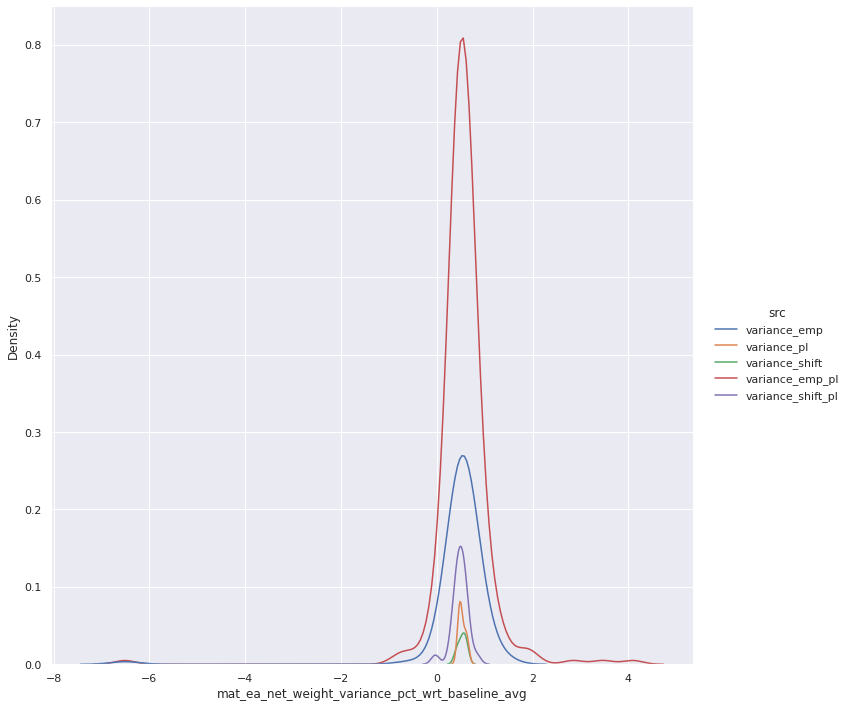

In [60]:
sns.set(rc={'figure.figsize':(25,10.27)})
sns.displot(df_consolidated, x = 'mat_ea_net_weight_variance_pct_wrt_baseline_avg', hue = 'src', kind = 'kde', height = 10)
#sns.displot(df_consolidated, x = 'mat_ea_net_weight_variance_pct_wrt_baseline_avg', hue = 'src', multiple = 'dodge', height = 10)

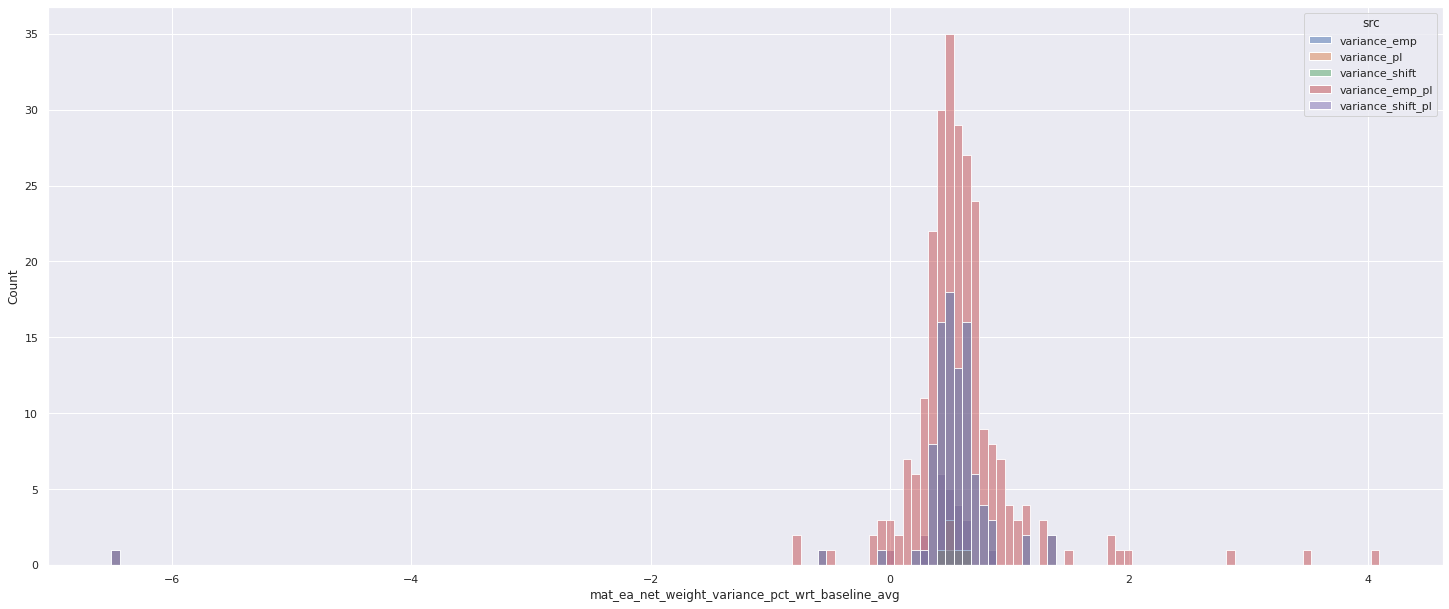

In [61]:
sns.set(rc={'figure.figsize':(25,10.27)})
sns.histplot(x    = "mat_ea_net_weight_variance_pct_wrt_baseline_avg",
             data = df_consolidated,
             hue  = 'src')

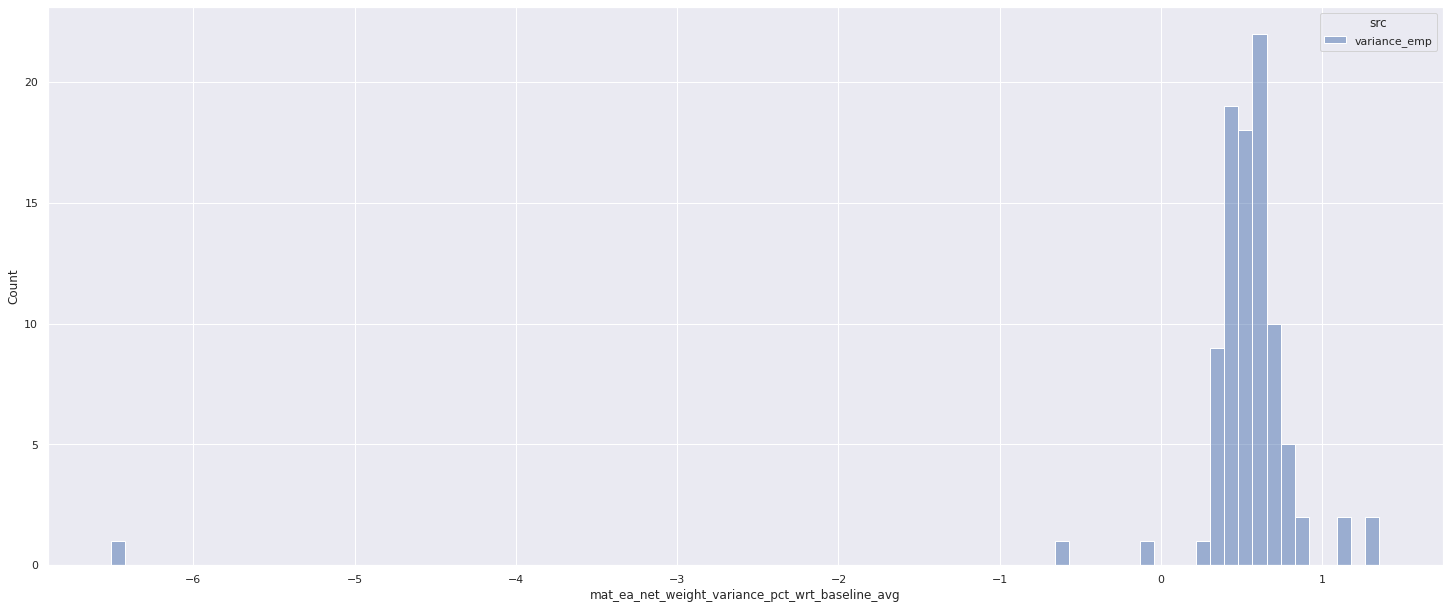

In [62]:
sns.set(rc={'figure.figsize':(25,10.27)})
sns.histplot(x    = "mat_ea_net_weight_variance_pct_wrt_baseline_avg",
             data = temp1,
             hue  = 'src')

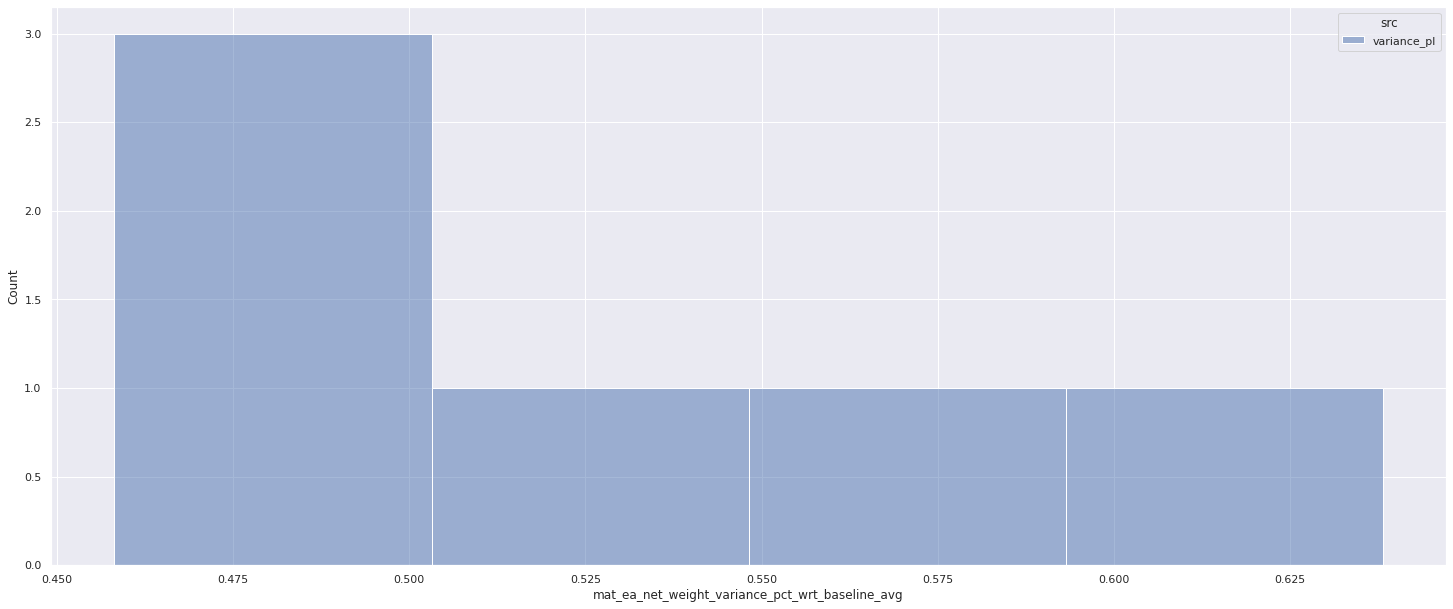

In [63]:
sns.set(rc={'figure.figsize':(25,10.27)})
sns.histplot(x    = "mat_ea_net_weight_variance_pct_wrt_baseline_avg",
             data = temp2,
             hue  = 'src')

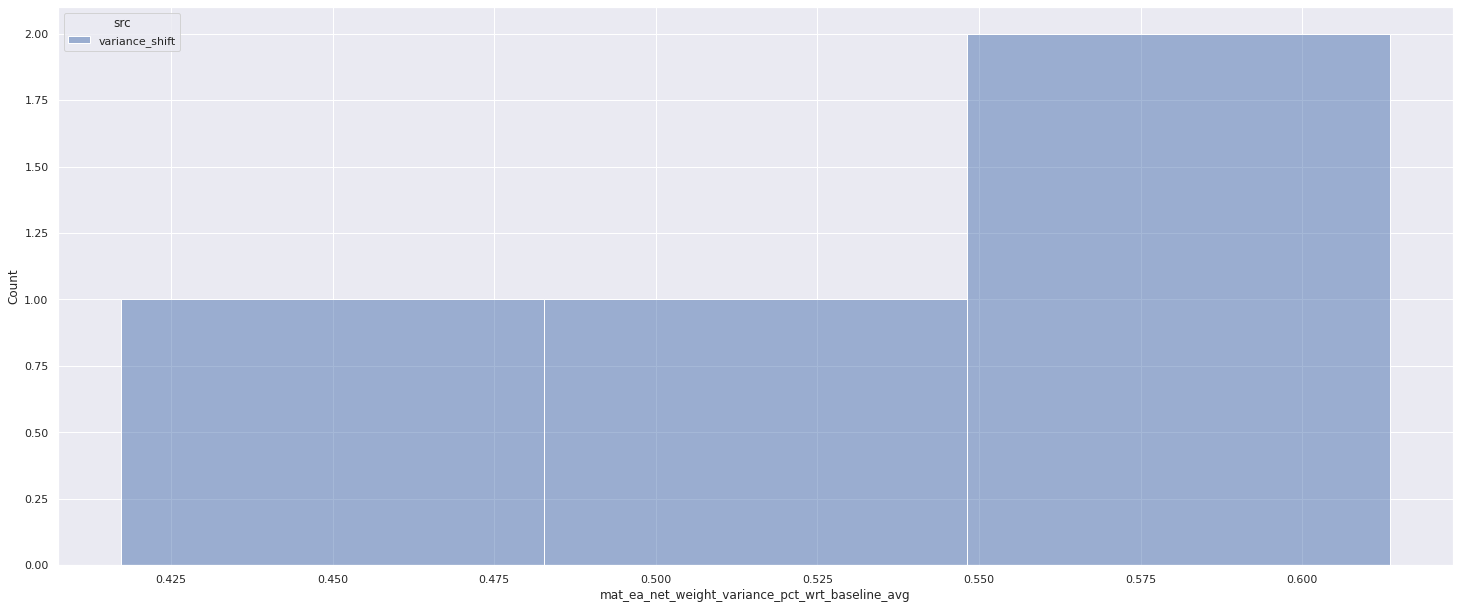

In [64]:
sns.set(rc={'figure.figsize':(25,10.27)})
sns.histplot(x    = "mat_ea_net_weight_variance_pct_wrt_baseline_avg",
             data = temp3,
             hue  = 'src')

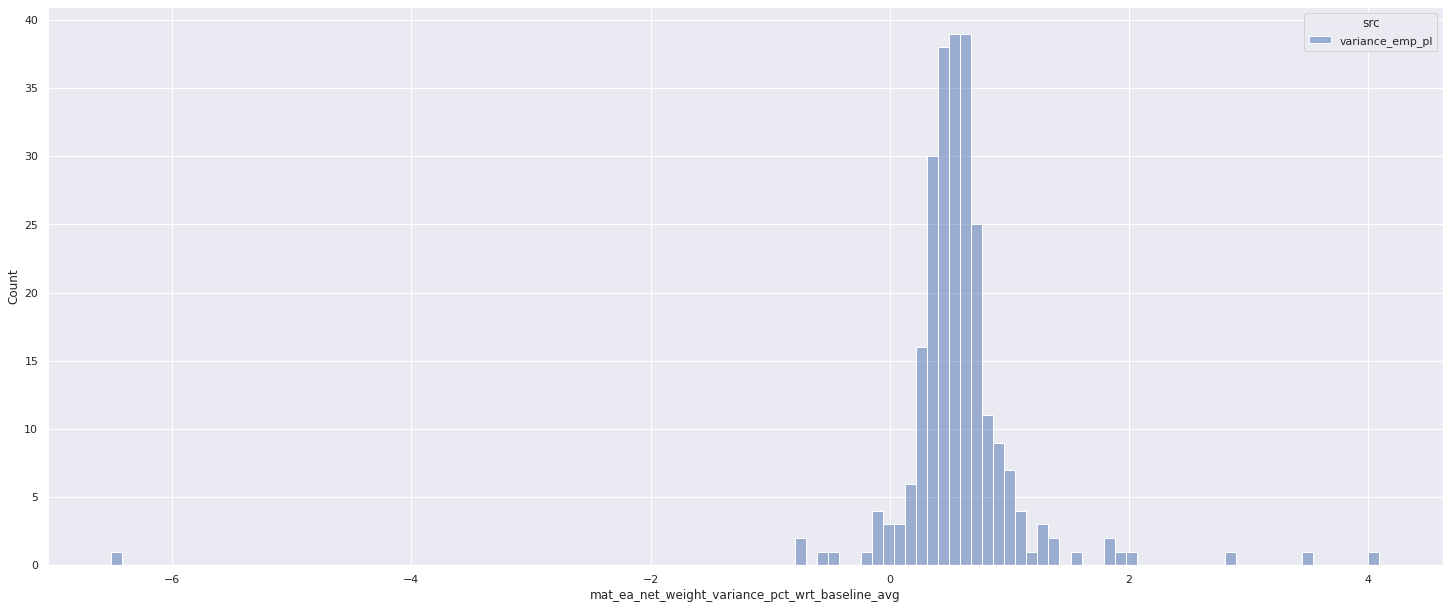

In [65]:
sns.set(rc={'figure.figsize':(25,10.27)})
sns.histplot(x    = "mat_ea_net_weight_variance_pct_wrt_baseline_avg",
             data = temp4,
             hue  = 'src')

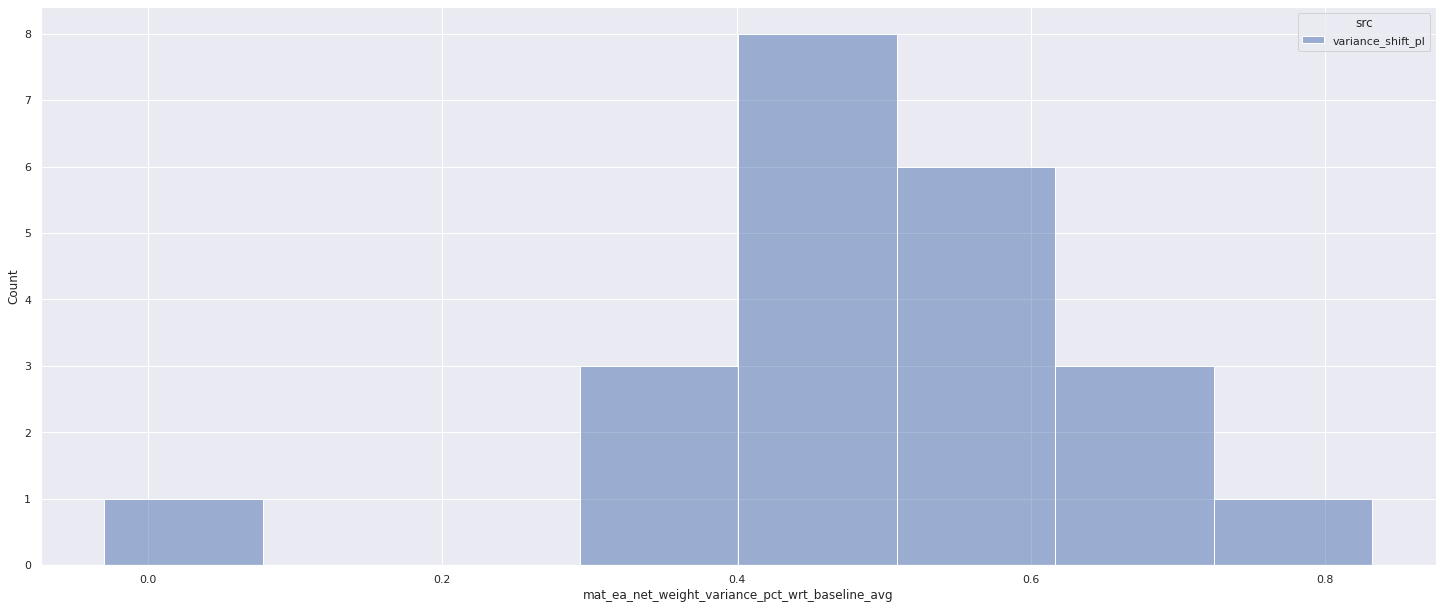

In [66]:
sns.set(rc={'figure.figsize':(25,10.27)})
sns.histplot(x    = "mat_ea_net_weight_variance_pct_wrt_baseline_avg",
             data = temp5,
             hue  = 'src')

In [67]:
[round(np.var(x, ddof=1),3) for x in [df_pl_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                                    , df_shift_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                                    , df_emp_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                                    , df_shift_process_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                                    , df_emp_pl_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                                    ]
 ]

[0.005, 0.007, 0.592, 0.027, 0.421]

In [68]:
from scipy.stats import bartlett
alpha = 0.05
stat, p_bartlet = bartlett(df_pl_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                        , df_shift_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                        , df_shift_process_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                        )
if p_bartlet <= alpha:
    print(p_bartlet,": small p-value suggests that populations do not have equal variances")
else:
    print(p_bartlet, ": large p-value suggests that our data is homogeneous")

0.08670543641308535 : large p-value suggests that our data is homogeneous


In [69]:
from scipy.stats import bartlett
alpha = 0.05
stat, p_bartlet = bartlett(df_emp_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                        , df_pl_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                        , df_emp_pl_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                        )
if p_bartlet <= alpha:
    print(p_bartlet,": small p-value suggests that populations do not have equal variances")
else:
    print(p_bartlet, ": large p-value suggests that our data is homogeneous")

2.6888898536961047e-05 : small p-value suggests that populations do not have equal variances


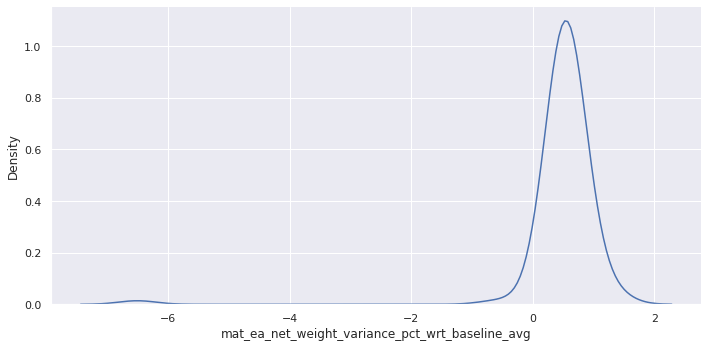

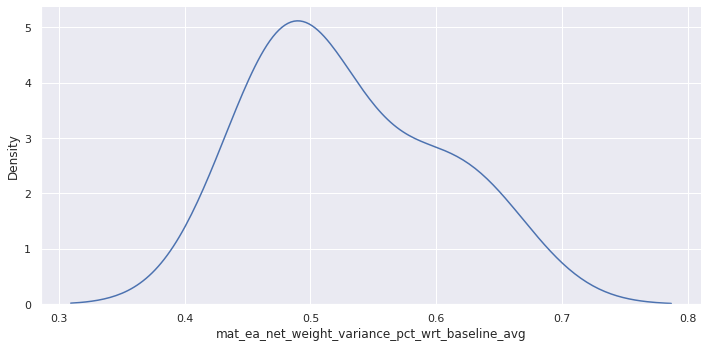

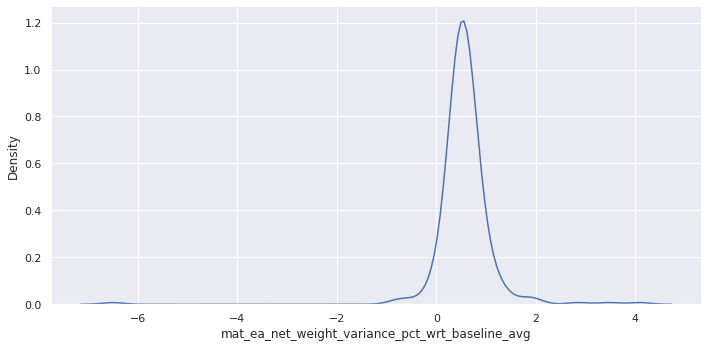

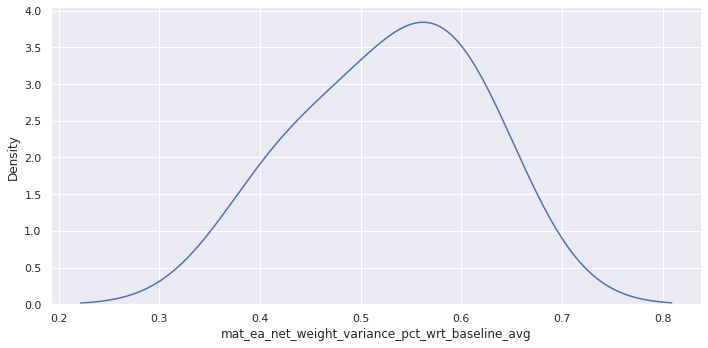

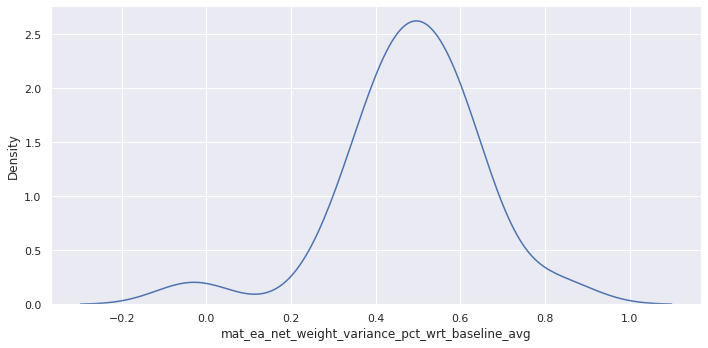

In [70]:
import seaborn as sns
sns.displot(df_emp_stats, x = 'mat_ea_net_weight_variance_pct_wrt_baseline_avg', kind = 'kde', height = 5, aspect = 2)
sns.displot(df_pl_stats, x = 'mat_ea_net_weight_variance_pct_wrt_baseline_avg', kind = 'kde', height = 5, aspect = 2)
sns.displot(df_emp_pl_stats, x = 'mat_ea_net_weight_variance_pct_wrt_baseline_avg', kind = 'kde', height=5, aspect=2)
sns.displot(df_shift_stats, x = 'mat_ea_net_weight_variance_pct_wrt_baseline_avg', kind = 'kde', height = 5,aspect = 2)
sns.displot(df_shift_process_stats, x = 'mat_ea_net_weight_variance_pct_wrt_baseline_avg', kind = 'kde', height=5, aspect = 2)

In [72]:
from scipy.stats import f 
dfn = len([df_pl_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg'],df_shift_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg'],df_shift_process_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']])-1
dfd = len(df) - len([df_pl_stats,df_shift_stats,df_shift_process_stats])
f_crit = f.ppf(1-alpha,dfn,dfd)
print(f_crit)

2.9957598092862328


# Anova also analyze variance of differnt groups and evaluate whether we have to reject The null hypothesis and accept alternate hypothesis 
# For that Anova calculate f-value and p-value. 
# P-value:-p-value is used to evaluate hypothesis results.
# P-value is a number between 0 and 1. 
# If p-value<0.05 we have to reject null hypothesis and p-value>0.05 we have to accept null hypothesis. 
# F-value:-f-value is the ratio of variance between groups and variance within groups. 
# If f-value is close to 1 then we say that our null hypothesis is true i.e samples have equal mean and F-value is greater than 1 then samples have quite different mean values.

# Before performing anova test Anova assumes following points. 
# Anova assumptions: 
# 1.Normality:-samples are taken from normal distribution. 
# To check whether data is normally distributed or not Anova use shapiro-wilks test 
# 2.Each sample is independent of other sample. 
# 3.Variance:- variance should be same. 
# To check whether variance between groups are equal Anova use levene/barlett test.

# **Interpretation**
# H0: the sample has a Gaussian distribution.
# H1: the sample does not have a Gaussian distribution.
# A small p (≤ 0.05), reject the null hypothesis. This is strong evidence that the null hypothesis is invalid.
# A large p (> 0.05) means the alternate hypothesis is weak, so you accept the null hypothesis.

In [73]:
from scipy import stats
from scipy.stats import shapiro

print(df.mat_ea_net_weight_variance_pct_wrt_baseline.mean())
#print(stats.shapiro(np.array(df['mat_ea_net_weight_variance_pct_wrt_baseline'])))
print(stats.shapiro(np.array(df_pl_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg'])))
print(stats.shapiro(np.array(df_shift_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg'])))
print(stats.shapiro(np.array(df_shift_process_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg'])))
print(stats.shapiro(np.array(df_emp_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg'])))
print(stats.shapiro(np.array(df_emp_pl_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg'])))


0.5371731504824733
(0.8900242447853088, 0.31831488013267517)
(0.9609816074371338, 0.7850847840309143)
(0.9112995266914368, 0.05032500624656677)
(0.28426802158355713, 3.3578649919099447e-19)
(0.5507125854492188, 4.402013456227868e-25)


In [74]:
from scipy.stats import bartlett
alpha = 0.05
stat, p_bartlet = bartlett(df_pl_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                        , df_shift_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                        , df_shift_process_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                        )
if p_bartlet <= alpha:
    print(p_bartlet,": small p-value suggests that populations do not have equal variances")
else:
    print(p_bartlet, ": large p-value suggests that our data is homogeneous")

0.08670543641308535 : large p-value suggests that our data is homogeneous


In [75]:
df_pl_stats[['process_id', 'mat_ea_net_weight_variance_pct_wrt_baseline_avg']]

,process_id,mat_ea_net_weight_variance_pct_wrt_baseline_avg
3,1484134852,0.638176
2,1442918540,0.592938
0,1274257684,0.513772
1,1274257694,0.491107
4,1512642512,0.479769
5,1578480702,0.458149


In [76]:
p_levene=stats.levene(df_pl_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                        , df_shift_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                        , df_shift_process_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg'])
print("p_levene",p_levene)
if p_levene[1] <= alpha:
    print(p_levene,": small p-value suggests that populations do not have equal variances")
else:
    print(p_levene, ": large p-value suggests that our data is homogeneous")

p_levene LeveneResult(statistic=0.9894349522618181, pvalue=0.3839902456801124)
LeveneResult(statistic=0.9894349522618181, pvalue=0.3839902456801124) : large p-value suggests that our data is homogeneous


In [77]:
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import bartlett

shapiro_shift_pl = shapiro(np.array(df_shift_process_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']))
print('shapiro_shift_pl stat=%.3f, p=%.3f' % (shapiro_shift_pl[0], shapiro_shift_pl[1]))
if shapiro_shift_pl[1] > 0.05:
	print('Null Hypothesis Accepted : Probably Gaussian')
else:
	print('Null Hypothesis Rejected : Probably not Gaussian')
 
shapiro_emp_pl = shapiro(np.array(df_emp_pl_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']))
print('shapiro_emp_pl stat=%.3f, p=%.3f' % (shapiro_emp_pl[0], shapiro_emp_pl[1]))
if shapiro_emp_pl[1] > 0.05:
	print('Null Hypothesis Accepted : Probably Gaussian')
else:
	print('Null Hypothesis Rejected : Probably not Gaussian')
 
levene_emp_pl_vs_shift_pl = levene(df_emp_pl_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                                 , df_shift_process_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg'])
print("levene_emp_pl_vs_shift_pl", levene_emp_pl_vs_shift_pl)

if levene_emp_pl_vs_shift_pl[1] <= alpha:
    print(levene_emp_pl_vs_shift_pl[1],": small p-value suggests that populations do not have equal variances")
else:
    print(levene_emp_pl_vs_shift_pl[1], ": large p-value suggests that our data is homogeneous")

bartlet_emp_pl_vs_shift_pl = bartlett(df_pl_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                                    , df_shift_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                                    , df_shift_process_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg']
                        )
print("bartlet_emp_pl_vs_shift_pl", bartlet_emp_pl_vs_shift_pl)
if bartlet_emp_pl_vs_shift_pl[1] <= alpha:
    print(bartlet_emp_pl_vs_shift_pl[1],": small p-value suggests that populations do not have equal variances")
else:
    print(bartlet_emp_pl_vs_shift_pl[1], ": large p-value suggests that our data is homogeneous")    

shapiro_shift_pl stat=0.911, p=0.050
Null Hypothesis Accepted : Probably Gaussian
shapiro_emp_pl stat=0.551, p=0.000
Null Hypothesis Rejected : Probably not Gaussian
levene_emp_pl_vs_shift_pl LeveneResult(statistic=2.006508256659995, pvalue=0.15776132160767492)
0.15776132160767492 : large p-value suggests that our data is homogeneous
bartlet_emp_pl_vs_shift_pl BartlettResult(statistic=4.890477386869926, pvalue=0.08670543641308535)
0.08670543641308535 : large p-value suggests that our data is homogeneous


# **Types of Anova:**
# **One-way Anova:**-one way Anova is used to compare means of two or more samples using f-value and p-value. 
# **Two-way Anova:** in two way Anova, data are classified on the basis of two factors. 

# **Difference between one-way Anova and two-way Anova:** 
# One way anova compares three or more than three categorical gropus,compare their means and to evaluate whether there is difference between them.
# Hypothesis of one way-anova: 
# Null hypothesis(h0):-null hypothesis is that all groups of mean are equal,there is no difference between them. 
# Alternate hypothesis(h1):-alternate hypothesis states that there is difference between mean. 
# Two-way Anova compares means of three or more groups of data, where two independent variables are considered. 
# The hypothesis of two way Anova is same as one-way Anova.



In [78]:
F_value,P_value=stats.f_oneway(df_shift_stats[['mat_ea_net_weight_variance_pct_wrt_baseline_avg']],df_pl_stats[['mat_ea_net_weight_variance_pct_wrt_baseline_avg']])
print(F_value,P_value)
if F_value>1.0:
    print("******SAMPLES HAVE DIFFERENT MEAN******")
else:
    print("******SAMPLES HAVE EQUAL MEAN******")

if P_value<0.05:
    print("******REJECT NULL HYPOTHESIS******")
else:
    print("******ACCEPT NULL HYPOTHESIS******")    

[7.21427779e-05] [0.99343109]
******SAMPLES HAVE EQUAL MEAN******
******ACCEPT NULL HYPOTHESIS******


In [79]:
F_value,P_value=stats.f_oneway(df_shift_process_stats[['mat_ea_net_weight_variance_pct_wrt_baseline_avg']],df_pl_stats[['mat_ea_net_weight_variance_pct_wrt_baseline_avg']])
print(F_value,P_value)
if F_value>1.0:
    print("******SAMPLES HAVE DIFFERENT MEAN******")
else:
    print("******SAMPLES HAVE EQUAL MEAN******")

if P_value<0.05:
    print("******REJECT NULL HYPOTHESIS******")
else:
    print("******ACCEPT NULL HYPOTHESIS******")    

[0.42612779] [0.51962591]
******SAMPLES HAVE EQUAL MEAN******
******ACCEPT NULL HYPOTHESIS******


In [80]:
F_value,P_value=stats.f_oneway(df_emp_stats[['mat_ea_net_weight_variance_pct_wrt_baseline_avg']],df_pl_stats[['mat_ea_net_weight_variance_pct_wrt_baseline_avg']])
print(F_value,P_value)
if F_value>1.0:
    print("******SAMPLES HAVE DIFFERENT MEAN******")
else:
    print("******SAMPLES HAVE EQUAL MEAN******")

if P_value<0.05:
    print("******REJECT NULL HYPOTHESIS******")
else:
    print("******ACCEPT NULL HYPOTHESIS******")    

[0.02350575] [0.87846769]
******SAMPLES HAVE EQUAL MEAN******
******ACCEPT NULL HYPOTHESIS******


In [81]:
F_value,P_value=stats.f_oneway(df_emp_stats[['mat_ea_net_weight_variance_pct_wrt_baseline_avg']],df_emp_pl_stats[['mat_ea_net_weight_variance_pct_wrt_baseline_avg']])
print(F_value,P_value)
if F_value>1.0:
    print("******SAMPLES HAVE DIFFERENT MEAN******")
else:
    print("******SAMPLES HAVE EQUAL MEAN******")

if P_value<0.05:
    print("******REJECT NULL HYPOTHESIS******")
else:
    print("******ACCEPT NULL HYPOTHESIS******")    

[1.03005518] [0.31085693]
******SAMPLES HAVE DIFFERENT MEAN******
******ACCEPT NULL HYPOTHESIS******


In [82]:
from scipy.stats import kruskal
stat_kruskal, p_kruskal = kruskal(df_shift_process_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg'], df_emp_pl_stats['mat_ea_net_weight_variance_pct_wrt_baseline_avg'])
print('stat_kruskal = %.3f, p_kruskal = %.3f' % (stat_kruskal, p_kruskal))

if stat_kruskal > 1.0:
    print("******SAMPLES HAVE DIFFERENT MEAN******")
else:
    print("******SAMPLES HAVE EQUAL MEAN******")

if p_kruskal > 0.05:
	print('Null Hypothesis Accepted : Probably the same distribution')
else:
	print('Null Hypothesis Rejected : Probably different distributions')

stat_kruskal = 1.633, p_kruskal = 0.201
******SAMPLES HAVE DIFFERENT MEAN******
Null Hypothesis Accepted : Probably the same distribution
